In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
bg_transit_adi = pd.read_csv('../data/bg_transit_adi_state_county.csv', dtype={'bg_fips':str,'bg_county':str})

In [5]:
bg_transit_adi

bg_fips                                       address  \
0       010010201001          203 N Court St, Prattville, AL 36067   
1       010010201002          203 N Court St, Prattville, AL 36067   
2       010010202001          203 N Court St, Prattville, AL 36067   
3       010010202002          203 N Court St, Prattville, AL 36067   
4       010010203001          203 N Court St, Prattville, AL 36067   
...              ...                                           ...   
235040  560430003012           620 Big Horn Ave, Worland, WY 82401   
235041  560430003013           620 Big Horn Ave, Worland, WY 82401   
235042  560430003021           620 Big Horn Ave, Worland, WY 82401   
235043  560430003022           620 Big Horn Ave, Worland, WY 82401   
235044  560459511001  103 S Belle Fourche Ave, Moorcroft, WY 82721   

        transit_time  walking_time  ADI_NATRANK  ADI_STATERNK bg_state  \
0              20.08         20.08         85.0           7.0       AL   
1              37.30         37.30         52.0           2.0       AL   
2              20.33         20.33         88.0           8.0       AL   
3               8.40          8.40         82.0           6.0       AL   
4              42.63         42.63         71.0           5.0       AL   
...              ...           ...          ...           ...      ...   
235040         14.47         14.47         74.0          10.0       WY   
235041          7.37          7.37         68.0           9.0       WY   
235042         27.67         27.67         54.0           7.0       WY   
235043         29.00         29.00         53.0           7.0       WY   
235044           NaN        462.30         50.0           6.0       WY   

       bg_county bg_county_name  
0          01001        Autauga  
1          01001        Autauga  
2          01001        Autauga  
3          01001        Autauga  
4          01001        Autauga  
...          ...            ...  
235040     56043       Washakie  
235041     56043       Washakie  
235042     56043       Washakie  
235043     56043       Washakie  
235044     56045         Weston  

[235045 rows x 9 columns]

In [5]:
census = pd.read_csv('ACS/census-1620.csv', dtype={'bg_fips':str})

In [6]:
census = census.rename(columns={'%white':'white', '%black':'black', '%noschool':'noschool', '%bachelor':'bachelor', 
                                '%household_snap':'household_snap', '%unemployed':'unemployed', '%single_parent':'single_parent', 
                                '%married':'married', '%cohabit':'cohabit', '%hispanic':'hispanic'})

# 1. Linear Regression

## ~ ADI

In [7]:
adi_lm = smf.glm(formula = "transit_time ~ ADI_NATRANK", data=bg_transit_adi)
adi_res = adi_lm.fit()

In [8]:
adi_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           transit_time   No. Observations:               164193
Model:                            GLM   Df Residuals:                   164191
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          842.78
Method:                          IRLS   Log-Likelihood:            -7.8604e+05
Date:                Sun, 04 Dec 2022   Deviance:                   1.3838e+08
Time:                        22:25:41   Pearson chi2:                 1.38e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      32.9136      0.136    241.580      0.000      32.647      33.181
ADI_NATRANK    -0.0993      0.002    -40.015      0.000      -0.104      -0.094
===============================================================================
"""

**Rurality**

In [9]:
county_rurality = pd.read_csv('../resources/ruralurbancodes2013.csv', 
                          dtype = {'FIPS':str}, )

In [10]:
county_rurality['RUCC_2013'] = county_rurality['RUCC_2013'].astype(str)
county_rurality.Description = county_rurality.Description.str.strip()

In [11]:
def decide_urban_degree(text):
    
    if text in ['Metro - Counties in metro areas of 250,000 to 1 million population',
       'Metro - Counties in metro areas of fewer than 250,000 population', 
               'Metro - Counties in metro areas of 1 million population or more']:
        
        return 'Urban: Metro areas'
    
    elif text in ['Nonmetro - Urban population of 20,000 or more, adjacent to a metro area', 
                  'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area']:
        return 'Urban: Medium Non-metro areas'
    
    elif text in ['Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area',
                  'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area']:
        return 'Urban: Small Non-metro areas'
    
    elif text in ['Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area',
                  'Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area']:
        return 'Rural areas'
    else:
        return 'N/A'
                  

In [12]:
county_rurality['status'] = county_rurality.apply(lambda x:decide_urban_degree(x.Description), axis=1)

In [13]:
county_rurality = county_rurality.rename(columns={'FIPS':'bg_county'})

In [14]:
county_rurality

bg_county State        County_Name Population_2010 RUCC_2013  \
0        01001    AL     Autauga County          54,571       2.0   
1        01003    AL     Baldwin County         182,265       3.0   
2        01005    AL     Barbour County          27,457       6.0   
3        01007    AL        Bibb County          22,915       1.0   
4        01009    AL      Blount County          57,322       1.0   
...        ...   ...                ...             ...       ...   
3229     72151    PR  Yabucoa Municipio          37,941       1.0   
3230     72153    PR    Yauco Municipio          42,043       2.0   
3231     78010    VI   St. Croix Island          50,601       5.0   
3232     78020    VI    St. John Island           4,170       7.0   
3233     78030    VI  St. Thomas Island          51,634       5.0   

                                            Description  \
0     Metro - Counties in metro areas of 250,000 to ...   
1     Metro - Counties in metro areas of fewer than ...   
2     Nonmetro - Urban population of 2,500 to 19,999...   
3     Metro - Counties in metro areas of 1 million p...   
4     Metro - Counties in metro areas of 1 million p...   
...                                                 ...   
3229  Metro - Counties in metro areas of 1 million p...   
3230  Metro - Counties in metro areas of 250,000 to ...   
3231  Nonmetro - Urban population of 20,000 or more,...   
3232  Nonmetro - Urban population of 2,500 to 19,999...   
3233  Nonmetro - Urban population of 20,000 or more,...   

                             status  
0                Urban: Metro areas  
1                Urban: Metro areas  
2      Urban: Small Non-metro areas  
3                Urban: Metro areas  
4                Urban: Metro areas  
...                             ...  
3229             Urban: Metro areas  
3230             Urban: Metro areas  
3231  Urban: Medium Non-metro areas  
3232   Urban: Small Non-metro areas  
3233  Urban: Medium Non-metro areas  

[3234 rows x 7 columns]

In [15]:
state_rural_ratio = county_rurality.groupby('State').apply(lambda s: s.loc[s.status == 'Rural areas'].count() / s.loc[s.status != 'Rural areas'].count()).bg_county#.to_csv('rural_ratio.csv', index=False)
state_rural_ratio_df = pd.DataFrame({'state': pd.DataFrame(state_rural_ratio).index.tolist(), 
              'rural_urban_ratio': pd.DataFrame(state_rural_ratio).bg_county.tolist()})

In [16]:
county_rurality = county_rurality[['bg_county', 'status']]

**Merge rural to BGs**

In [17]:
bg_transit_adi = bg_transit_adi.merge(county_rurality.drop_duplicates(subset=['bg_county']), how='left', on='bg_county')

In [18]:
bg_transit_adi['rural'] = bg_transit_adi.status == 'Rural areas'

In [19]:
bg_transit_adi = bg_transit_adi.replace({False:0, True: 1})

In [20]:
bg_transit_adi

bg_fips                                       address  \
0       010010201001          203 N Court St, Prattville, AL 36067   
1       010010201002          203 N Court St, Prattville, AL 36067   
2       010010202001          203 N Court St, Prattville, AL 36067   
3       010010202002          203 N Court St, Prattville, AL 36067   
4       010010203001          203 N Court St, Prattville, AL 36067   
...              ...                                           ...   
235040  560430003012           620 Big Horn Ave, Worland, WY 82401   
235041  560430003013           620 Big Horn Ave, Worland, WY 82401   
235042  560430003021           620 Big Horn Ave, Worland, WY 82401   
235043  560430003022           620 Big Horn Ave, Worland, WY 82401   
235044  560459511001  103 S Belle Fourche Ave, Moorcroft, WY 82721   

        transit_time  walking_time  ADI_NATRANK  ADI_STATERNK bg_state  \
0              20.08         20.08         85.0           7.0       AL   
1              37.30         37.30         52.0           2.0       AL   
2              20.33         20.33         88.0           8.0       AL   
3               8.40          8.40         82.0           6.0       AL   
4              42.63         42.63         71.0           5.0       AL   
...              ...           ...          ...           ...      ...   
235040         14.47         14.47         74.0          10.0       WY   
235041          7.37          7.37         68.0           9.0       WY   
235042         27.67         27.67         54.0           7.0       WY   
235043         29.00         29.00         53.0           7.0       WY   
235044           NaN        462.30         50.0           6.0       WY   

       bg_county bg_county_name                        status  rural  
0          01001        Autauga            Urban: Metro areas      0  
1          01001        Autauga            Urban: Metro areas      0  
2          01001        Autauga            Urban: Metro areas      0  
3          01001        Autauga            Urban: Metro areas      0  
4          01001        Autauga            Urban: Metro areas      0  
...          ...            ...                           ...    ...  
235040     56043       Washakie  Urban: Small Non-metro areas      0  
235041     56043       Washakie  Urban: Small Non-metro areas      0  
235042     56043       Washakie  Urban: Small Non-metro areas      0  
235043     56043       Washakie  Urban: Small Non-metro areas      0  
235044     56045         Weston  Urban: Small Non-metro areas      0  

[235045 rows x 11 columns]

In [22]:
# adi_rural_lm = smf.glm(formula = "transit_time ~ ADI_NATRANK + rural", data=bg_transit_adi)
# adi_rural_res = adi_rural_lm.fit()

In [23]:
# adi_rural_res.summary()

## Census + Rural

In [21]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [22]:
d = bg_transit_adi.merge(census, how='left', on='bg_fips')

In [23]:
bg_transit_adi_census = bg_transit_adi.merge(census.drop_duplicates(subset=['bg_fips']), how='left', on='bg_fips')

In [24]:
bg_transit_adi_census

bg_fips                                       address  \
0       010010201001          203 N Court St, Prattville, AL 36067   
1       010010201002          203 N Court St, Prattville, AL 36067   
2       010010202001          203 N Court St, Prattville, AL 36067   
3       010010202002          203 N Court St, Prattville, AL 36067   
4       010010203001          203 N Court St, Prattville, AL 36067   
...              ...                                           ...   
235040  560430003012           620 Big Horn Ave, Worland, WY 82401   
235041  560430003013           620 Big Horn Ave, Worland, WY 82401   
235042  560430003021           620 Big Horn Ave, Worland, WY 82401   
235043  560430003022           620 Big Horn Ave, Worland, WY 82401   
235044  560459511001  103 S Belle Fourche Ave, Moorcroft, WY 82721   

        transit_time  walking_time  ADI_NATRANK  ADI_STATERNK bg_state  \
0              20.08         20.08         85.0           7.0       AL   
1              37.30         37.30         52.0           2.0       AL   
2              20.33         20.33         88.0           8.0       AL   
3               8.40          8.40         82.0           6.0       AL   
4              42.63         42.63         71.0           5.0       AL   
...              ...           ...          ...           ...      ...   
235040         14.47         14.47         74.0          10.0       WY   
235041          7.37          7.37         68.0           9.0       WY   
235042         27.67         27.67         54.0           7.0       WY   
235043         29.00         29.00         53.0           7.0       WY   
235044           NaN        462.30         50.0           6.0       WY   

       bg_county bg_county_name                        status  ...      black  \
0          01001        Autauga            Urban: Metro areas  ...   4.154303   
1          01001        Autauga            Urban: Metro areas  ...  16.337806   
2          01001        Autauga            Urban: Metro areas  ...  56.798867   
3          01001        Autauga            Urban: Metro areas  ...  59.467174   
4          01001        Autauga            Urban: Metro areas  ...  25.618132   
...          ...            ...                           ...  ...        ...   
235040     56043       Washakie  Urban: Small Non-metro areas  ...   0.000000   
235041     56043       Washakie  Urban: Small Non-metro areas  ...   0.000000   
235042     56043       Washakie  Urban: Small Non-metro areas  ...   0.000000   
235043     56043       Washakie  Urban: Small Non-metro areas  ...   0.000000   
235044     56045         Weston  Urban: Small Non-metro areas  ...   1.968732   

        noschool   bachelor  household_snap  unemployed  \
0       0.000000  15.702479       18.275862    1.666667   
1       0.000000  15.272727       20.347395    2.355072   
2       1.654846  10.638298       43.171806    1.818182   
3       0.000000  13.932584        8.959538    5.030181   
4       0.709939   9.229209        6.769826    3.103044   
...          ...        ...             ...         ...   
235040  0.722892   7.951807        0.000000    2.282158   
235041  0.000000   9.181970        5.730659    4.016064   
235042  0.000000   9.704251        0.000000    8.104575   
235043  0.000000  18.194842        4.812834    5.421687   
235044  0.000000  15.811258        1.030928    1.189061   

        median_household_income  single_parent    married    cohabit  \
0                       39167.0      12.413793  35.862069   0.000000   
1                       70699.0       3.722084  81.637717   2.233251   
2                       39750.0       9.251101  52.422907   8.370044   
3                       50221.0       0.000000  23.988439   4.913295   
4                       67813.0      10.831721  54.545455  15.377176   
...                         ...            ...        ...        ...   
235040                  45955.0      13.725490  38.970588  18.627451   
235041                  5

In [25]:
census_cols = ['white','black','noschool', 'bachelor', 
'household_snap', 'unemployed','single_parent', 'married', 
'cohabit', 'hispanic', 'rural']

In [26]:
bg_transit_adi_census.dropna(inplace=True)
d.dropna(inplace=True)

**Entire Data**

In [28]:
smf.glm(formula="""transit_time ~ white + black + noschool + bachelor + household_snap 
+ unemployed + single_parent + married + cohabit + hispanic + C(rural)""", data=d).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           transit_time   No. Observations:               153975
Model:                            GLM   Df Residuals:                   153963
Model Family:                Gaussian   Df Model:                           11
Link Function:               identity   Scale:                          820.08
Method:                          IRLS   Log-Likelihood:            -7.3502e+05
Date:                Sun, 04 Dec 2022   Deviance:                   1.2626e+08
Time:                        22:26:25   Pearson chi2:                 1.26e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.5452      0.570     23.772      0.000      12.428      14.662
C(rural)[T.1]     18.2901      1.472     12.429      0.000      15.406      21.174
white              0.0529      0.005     11.391      0.000       0.044       0.062
black              0.0176      0.006      3.072      0.002       0.006       0.029
noschool          -0.2461      0.024    -10.066      0.000      -0.294      -0.198
bachelor          -0.0287      0.007     -4.163      0.000      -0.042      -0.015
household_snap    -0.1643      0.007    -23.252      0.000      -0.178      -0.150
unemployed         0.0264      0.012      2.185      0.029       0.003       0.050
single_parent      0.1520      0.010     14.480      0.000       0.131       0.173
married            0.2981      0.005     66.174      0.000       0.289       0.307
cohabit            0.0158      0.011      1.409      0.159      -0.006       0.038
hispanic          -0.0183      0.004     -4.786      0.000      -0.026      -0.011
==================================================================================
"""

In [29]:
smf.glm(formula="""transit_time ~ black + noschool + bachelor + household_snap 
+ unemployed + single_parent + married + cohabit + hispanic + C(rural)""", data=d).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           transit_time   No. Observations:               153975
Model:                            GLM   Df Residuals:                   153964
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                          820.77
Method:                          IRLS   Log-Likelihood:            -7.3508e+05
Date:                Sun, 04 Dec 2022   Deviance:                   1.2637e+08
Time:                        22:26:37   Pearson chi2:                 1.26e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         18.5513      0.363     51.128      0.000      17.840      19.262
C(rural)[T.1]     18.5712      1.472     12.617      0.000      15.686      21.456
black             -0.0315      0.004     -8.336      0.000      -0.039      -0.024
noschool          -0.2989      0.024    -12.442      0.000      -0.346      -0.252
bachelor          -0.0395      0.007     -5.792      0.000      -0.053      -0.026
household_snap    -0.1645      0.007    -23.283      0.000      -0.178      -0.151
unemployed         0.0215      0.012      1.785      0.074      -0.002       0.045
single_parent      0.1513      0.010     14.408      0.000       0.131       0.172
married            0.2971      0.005     65.939      0.000       0.288       0.306
cohabit            0.0158      0.011      1.411      0.158      -0.006       0.038
hispanic          -0.0364      0.003    -10.448      0.000      -0.043      -0.030
==================================================================================
"""

### VIF 

In [27]:
census_X = bg_transit_adi_census[census_cols]
transit_y = bg_transit_adi_census.transit_time

In [56]:
d.dropna(inplace=True)

census_X = d[census_cols]
transit_y = d.transit_time

In [57]:
vif_data = pd.DataFrame()
vif_data['feature'] = census_X.columns

vif_data['vif'] = [variance_inflation_factor(census_X.values, i)
                   for i in range(len(census_X.columns))]

In [58]:
vif_data

feature       vif
0           black  1.910191
1        noschool  1.518213
2        bachelor  3.605152
3  household_snap  3.078195
4      unemployed  2.073014
5   single_parent  2.304552
6         married  4.168369
7         cohabit  1.855887
8        hispanic  2.167128
9           rural  1.004094

VIF values are between 1 and 5, which means that moderate correlation between a given explanatory variable and other explanatory variables in the model, but this is often not severe enough to require attention.

In [33]:
# census_lm = sm.GLM(transit_y, sm.add_constant(census_X))
# census_res = census_lm.fit()

In [34]:
# census_res.summary()

## Fixed by Rural/Urban

In [30]:
bg_transit_adi_census

bg_fips                               address  transit_time  \
0       010010201001  203 N Court St, Prattville, AL 36067         20.08   
1       010010201002  203 N Court St, Prattville, AL 36067         37.30   
2       010010202001  203 N Court St, Prattville, AL 36067         20.33   
3       010010202002  203 N Court St, Prattville, AL 36067          8.40   
4       010010203001  203 N Court St, Prattville, AL 36067         42.63   
...              ...                                   ...           ...   
235039  560430003011   620 Big Horn Ave, Worland, WY 82401          9.72   
235040  560430003012   620 Big Horn Ave, Worland, WY 82401         14.47   
235041  560430003013   620 Big Horn Ave, Worland, WY 82401          7.37   
235042  560430003021   620 Big Horn Ave, Worland, WY 82401         27.67   
235043  560430003022   620 Big Horn Ave, Worland, WY 82401         29.00   

        walking_time  ADI_NATRANK  ADI_STATERNK bg_state bg_county  \
0              20.08         85.0           7.0       AL     01001   
1              37.30         52.0           2.0       AL     01001   
2              20.33         88.0           8.0       AL     01001   
3               8.40         82.0           6.0       AL     01001   
4              42.63         71.0           5.0       AL     01001   
...              ...          ...           ...      ...       ...   
235039          9.72         79.0          10.0       WY     56043   
235040         14.47         74.0          10.0       WY     56043   
235041          7.37         68.0           9.0       WY     56043   
235042         27.67         54.0           7.0       WY     56043   
235043         29.00         53.0           7.0       WY     56043   

       bg_county_name                        status  ...      black  noschool  \
0             Autauga            Urban: Metro areas  ...   4.154303  0.000000   
1             Autauga            Urban: Metro areas  ...  16.337806  0.000000   
2             Autauga            Urban: Metro areas  ...  56.798867  1.654846   
3             Autauga            Urban: Metro areas  ...  59.467174  0.000000   
4             Autauga            Urban: Metro areas  ...  25.618132  0.709939   
...               ...                           ...  ...        ...       ...   
235039       Washakie  Urban: Small Non-metro areas  ...   0.000000  3.084833   
235040       Washakie  Urban: Small Non-metro areas  ...   0.000000  0.722892   
235041       Washakie  Urban: Small Non-metro areas  ...   0.000000  0.000000   
235042       Washakie  Urban: Small Non-metro areas  ...   0.000000  0.000000   
235043       Washakie  Urban: Small Non-metro areas  ...   0.000000  0.000000   

         bachelor  household_snap  unemployed  median_household_income  \
0       15.702479       18.275862    1.666667                  39167.0   
1       15.272727       20.347395    2.355072                  70699.0   
2       10.638298       43.171806    1.818182                  39750.0   
3       13.932584        8.959538    5.030181                  50221.0   
4        9.229209        6.769826    3.103044                  67813.0   
...           ...             ...         ...                      ...   
235039  15.681234        2.364865    0.000000                  52330.0   
235040   7.951807        0.000000    2.282158                  45955.0   
235041   9.181970        5.730659    4.016064                  58819.0   
235042   9.704251        0.000000    8.104575                  57460.0   
235043  18.194842        4.812834    5.421687                  67018.0   

        single_parent    married    cohabit   hispanic  
0           12.413793  35.862069   0.000000   3.560831  
1            3.722084  81.637717   2.233251   0.710339  
2            9.251101  52.422907   8.370044   4.249292  
3            0.000000  23.988439   4.913295   0.000000  
4           10.831721  54.545455  15.377176   6.181319  
...               ...        ...        ...        ... 

In [31]:
bg_rural = bg_transit_adi_census.loc[bg_transit_adi_census['rural'] == 1]

In [32]:
bg_urban = bg_transit_adi_census.loc[bg_transit_adi_census['rural'] == 0]

**Rural**

In [35]:
smf.glm(formula="""transit_time ~ white + black + noschool + bachelor + household_snap 
+ unemployed + single_parent + married + cohabit + hispanic""", data=bg_rural).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           transit_time   No. Observations:                  381
Model:                            GLM   Df Residuals:                      370
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                          10996.
Method:                          IRLS   Log-Likelihood:                -2307.7
Date:                Sun, 04 Dec 2022   Deviance:                   4.0684e+06
Time:                        22:30:54   Pearson chi2:                 4.07e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         60.2635     67.720      0.890      0.374     -72.466     192.993
white              0.0664      0.609      0.109      0.913      -1.126       1.259
black              1.2359      0.662      1.867      0.062      -0.062       2.533
noschool          -4.3117      2.896     -1.489      0.137      -9.989       1.365
bachelor          -0.6075      0.784     -0.775      0.438      -2.144       0.929
household_snap    -1.7714      0.676     -2.621      0.009      -3.096      -0.447
unemployed         1.2200      1.127      1.082      0.279      -0.990       3.430
single_parent     -1.1709      1.170     -1.001      0.317      -3.463       1.121
married            0.3508      0.503      0.697      0.486      -0.635       1.336
cohabit           -1.4681      1.099     -1.336      0.182      -3.622       0.686
hispanic           0.4920      0.506      0.972      0.331      -0.500       1.484
==================================================================================
"""

In [64]:
smf.glm(formula="""transit_time ~ white + black + noschool + bachelor + household_snap 
+ unemployed + single_parent + married + cohabit + hispanic""", data=bg_urban).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           transit_time   No. Observations:               153594
Model:                            GLM   Df Residuals:                   153583
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                          793.93
Method:                          IRLS   Log-Likelihood:            -7.3071e+05
Date:                Mon, 05 Dec 2022   Deviance:                   1.2193e+08
Time:                        23:41:44   Pearson chi2:                 1.22e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.5272      0.561     24.115      0.000      12.428      14.627
white              0.0528      0.005     11.549      0.000       0.044       0.062
black              0.0156      0.006      2.761      0.006       0.005       0.027
noschool          -0.2436      0.024    -10.119      0.000      -0.291      -0.196
bachelor          -0.0276      0.007     -4.071      0.000      -0.041      -0.014
household_snap    -0.1616      0.007    -23.234      0.000      -0.175      -0.148
unemployed         0.0249      0.012      2.097      0.036       0.002       0.048
single_parent      0.1539      0.010     14.897      0.000       0.134       0.174
married            0.2978      0.004     67.161      0.000       0.289       0.307
cohabit            0.0182      0.011      1.649      0.099      -0.003       0.040
hispanic          -0.0191      0.004     -5.083      0.000      -0.027      -0.012
==================================================================================
"""

In [51]:
d.pvalues.values

array([1.72588548e-128, 7.49943832e-031, 5.76827186e-003, 4.53815258e-024,
       4.67494766e-005, 2.04237880e-119, 3.60037407e-002, 3.45020130e-050,
       0.00000000e+000, 9.90472165e-002, 3.70978622e-007])

## fixed by state

In [37]:
all_states = list(bg_transit_adi_census.bg_state.unique())

### ~ ADI

In [38]:
state_adi_df = pd.DataFrame(columns=['intercept', 'ADI_NATRANK'])

In [39]:
for i, state in enumerate(all_states):
    
    state_dat = bg_transit_adi_census.loc[bg_transit_adi_census.bg_state == state]
    
    adi_lm = smf.glm(formula = "transit_time ~ ADI_NATRANK", data=state_dat)
    adi_state_res = adi_lm.fit()
            
    state_adi_df.loc[i] = adi_state_res.params.values

In [40]:
state_adi_df = state_adi_df.set_index(pd.Index(all_states))
state_adi_df = state_adi_df.round(3)

state_adi_df.reset_index(inplace=True)
state_adi_df = state_adi_df.rename(columns = {'index':'states'})

In [41]:
#state_adi_df.to_csv('../state_adi_regression.csv', index=False)

### Census + rural

In [58]:
state_census_df = pd.DataFrame(columns=['intercept', 'white','black', 'noschool', 'bachelor', 'snap', 'unemploy', 'single_parent', 
                                 'married', 'cohabit', 'hispanic', 'rural'])
state_census_df_pvalues = pd.DataFrame(columns=['intercept', 'white','black', 'noschool', 'bachelor', 'snap', 'unemploy', 'single_parent', 
                                 'married', 'cohabit', 'hispanic', 'rural'])

In [59]:
for i, state in enumerate(all_states):
    
    state_dat = bg_transit_adi_census.loc[bg_transit_adi_census.bg_state == state]
    
    census_X = state_dat[census_cols]
    transit_y = state_dat.transit_time
    census_lm = sm.GLM(transit_y, sm.add_constant(census_X))
    
#     census_lm = smf.glm(formula="""transit_time ~ black + noschool + bachelor + household_snap 
# + unemployed + single_parent + married + cohabit + hispanic + C(rural)""", data=state_dat)

    census_res = census_lm.fit()
            
    state_census_df.loc[i] = census_res.params.values
    state_census_df_pvalues.loc[i] = census_res.pvalues.values

/home/mlee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/mlee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/mlee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/mlee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/hom

In [60]:
state_census_df = state_census_df.set_index(pd.Index(all_states))
state_census_df_pvalues = state_census_df_pvalues.set_index(pd.Index(all_states))

state_census_df = state_census_df.round(2)
state_census_df_pvalues = state_census_df_pvalues.round(2)

In [61]:
state_census_df.reset_index(inplace=True)
state_census_df_pvalues.reset_index(inplace=True)

state_census_df = state_census_df.rename(columns = {'index':'states'})
state_census_df_pvalues = state_census_df_pvalues.rename(columns = {'index':'states'})

In [65]:
state_census_df#.to_csv('../state_census_reg.csv', index=False)

states  intercept  white  black  noschool  bachelor  snap  unemploy  \
0      AL      29.00  -0.03  -0.10     -0.02      0.01 -0.09     -0.05   
1      AK       9.71   0.08  -0.19     -0.43     -0.01 -0.14     -0.12   
2      AZ      25.42  -0.03  -0.09     -0.50     -0.03 -0.18     -0.00   
3      AR       9.99   0.10   0.03     -0.10      0.04 -0.06     -0.02   
4      CA      15.03   0.06  -0.03     -0.27     -0.10 -0.06      0.20   
5      CO      15.11   0.01  -0.13     -0.14      0.05 -0.10      0.04   
6      CT      20.04   0.03  -0.17     -0.18     -0.01 -0.07     -0.02   
7      DE      41.14  -0.14  -0.38     -0.01     -0.20 -0.16      0.15   
8      DC      12.75   0.01   0.05     -0.41     -0.11  0.12     -0.05   
9      FL      16.50   0.05  -0.00     -0.35      0.08 -0.18     -0.01   
10     GA      37.46  -0.14  -0.12     -0.28     -0.06 -0.17     -0.07   
11     HI      -3.93   0.23  -0.24     -0.68      0.28  0.02      0.07   
12     ID      11.95   0.03   0.41     -0.13      0.01 -0.18     -0.09   
13     IL      17.70   0.03  -0.03     -0.13     -0.12 -0.13      0.02   
14     IN      19.51  -0.03  -0.03     -0.05      0.08 -0.20     -0.03   
15     IA      28.12  -0.11  -0.18     -0.18      0.12 -0.05     -0.11   
16     KS      21.65  -0.11  -0.13     -0.07      0.11 -0.06      0.06   
17     KY      31.66  -0.12  -0.22      0.20      0.01 -0.20     -0.01   
18     LA      36.47  -0.13  -0.15     -0.08     -0.07 -0.12     -0.10   
19     ME       9.84   0.05  -0.21     -0.54     -0.07 -0.11     -0.06   
20     MD      45.20  -0.34  -0.31     -0.25     -0.01 -0.21     -0.08   
21     MA       4.14   0.35   0.02     -0.47     -0.36 -0.04      0.00   
22     MI      23.91  -0.02  -0.09      0.03     -0.03 -0.16     -0.02   
23     MN      11.24   0.06  -0.00      0.01     -0.02 -0.16     -0.07   
24     MS      19.53   0.09   0.02      0.31     -0.04 -0.07     -0.02   
25     MO      14.52   0.03  -0.06     -0.24     -0.02 -0.10     -0.00   
26     MT      16.56   0.06  -0.82     -0.07     -0.12 -0.22     -0.28   
27     NE       8.89   0.01   0.06     -0.21      0.06 -0.22     -0.04   
28     NV      19.93  -0.01  -0.10     -0.22      0.19 -0.14     -0.09   
29     NH      12.50   0.08  -0.18     -0.23     -0.11 -0.30     -0.24   
30     NJ      18.93   0.07  -0.11     -0.14      0.07 -0.12      0.02   
31     NM      40.53  -0.24  -0.48     -0.19     -0.12 -0.16      0.19   
32     NY       7.30   0.16  -0.01     -0.17     -0.23 -0.12      0.04   
33     NC      30.73  -0.07  -0.08     -0.02     -0.09 -0.20      0.01   
34     ND      24.47  -0.15  -0.10     -0.20      0.17 -0.06     -0.22   
35     OH      21.68  -0.03  -0.09     -0.14      0.02 -0.13     -0.03   
36     OK      21.28  -0.05   0.04     -0.17      0.13 -0.13     -0.14   
37     OR      17.30   0.06  -0.08     -0.30     -0.17 -0.14     -0.10   
38     PA      12.31   0.08  -0.02     -0.18     -0.07 -0.08      0.00   
39     RI       4.12   0.13  -0.15     -0.16      0.03  0.08     -0.07   
40     SC      46.09  -0.20  -0.22      0.29     -0.13 -0.28     -0.07   
41     SD      17.21  -0.07  -0.36      0.47      0.18 -0.20      0.54   
42     TN      21.42  -0.04   0.02     -0.19     -0.01 -0.23     -0.09   
43     TX      14.54   0.03   0.05     -0.26      0.10 -0.10     -0.01   
44     UT       8.55   0.03  -0.01     -0.27      0.06 -0.11     -0.02   
45     VT      -3.14   0.16   0.04     -0.26     -0.06 -0.20     -0.06   
46     VA      27.02  -0.08  -0.09     -0.29     -0.14 -0.22      0.37   
47     WA      21.36  -0.00  -0.16     -0.29     -0.13 -0.20      0.13   
48     WV       1.92   0.12  -0.09      0.58     -0.03  0.05     -0.22   
49     WI      10.70   0.08   0.03     -0.10     -0.03 -0.11     -0.08   
50     WY      -4.43   0.12   0.52      0.17     -0.01 -0.04      0.05   

    single_parent  married  cohabit  hispanic   rural  
0            0.12     0.17    -0.04     -0.11   -0.00  
1            0.12     0.29     0.03      0

In [63]:
state_census_df_pvalues

states  intercept  white  black  noschool  bachelor  snap  unemploy  \
0      AL       0.00   0.66   0.10      0.89      0.82  0.01      0.43   
1      AK       0.19   0.25   0.24      0.49      0.95  0.22      0.50   
2      AZ       0.00   0.45   0.20      0.00      0.52  0.00      0.95   
3      AR       0.05   0.05   0.51      0.57      0.38  0.17      0.81   
4      CA       0.00   0.00   0.25      0.00      0.00  0.02      0.00   
5      CO       0.00   0.78   0.01      0.26      0.08  0.01      0.56   
6      CT       0.00   0.39   0.00      0.25      0.81  0.06      0.74   
7      DE       0.00   0.14   0.00      0.99      0.03  0.08      0.30   
8      DC       0.09   0.89   0.52      0.15      0.05  0.09      0.54   
9      FL       0.00   0.03   0.89      0.00      0.00  0.00      0.68   
10     GA       0.00   0.00   0.00      0.02      0.04  0.00      0.17   
11     HI       0.36   0.00   0.17      0.06      0.00  0.82      0.65   
12     ID       0.09   0.65   0.03      0.58      0.77  0.00      0.43   
13     IL       0.00   0.19   0.15      0.17      0.00  0.00      0.57   
14     IN       0.00   0.32   0.31      0.57      0.00  0.00      0.44   
15     IA       0.00   0.11   0.06      0.45      0.03  0.44      0.33   
16     KS       0.00   0.00   0.01      0.60      0.00  0.20      0.40   
17     KY       0.00   0.17   0.02      0.45      0.82  0.00      0.89   
18     LA       0.00   0.01   0.00      0.56      0.07  0.00      0.03   
19     ME       0.41   0.67   0.21      0.24      0.33  0.11      0.69   
20     MD       0.00   0.00   0.00      0.40      0.87  0.01      0.58   
21     MA       0.77   0.01   0.91      0.40      0.02  0.82      0.99   
22     MI       0.00   0.31   0.00      0.73      0.27  0.00      0.48   
23     MN       0.01   0.09   0.98      0.95      0.56  0.00      0.47   
24     MS       0.04   0.36   0.81      0.15      0.58  0.18      0.78   
25     MO       0.00   0.36   0.09      0.07      0.39  0.00      0.93   
26     MT       0.01   0.29   0.01      0.91      0.07  0.01      0.05   
27     NE       0.30   0.89   0.58      0.33      0.44  0.03      0.83   
28     NV       0.00   0.69   0.05      0.07      0.00  0.00      0.16   
29     NH       0.14   0.34   0.32      0.50      0.10  0.00      0.07   
30     NJ       0.00   0.00   0.00      0.22      0.02  0.00      0.76   
31     NM       0.00   0.00   0.06      0.61      0.26  0.06      0.21   
32     NY       0.00   0.00   0.33      0.00      0.00  0.00      0.08   
33     NC       0.00   0.04   0.02      0.85      0.00  0.00      0.84   
34     ND       0.01   0.13   0.48      0.63      0.03  0.56      0.25   
35     OH       0.00   0.21   0.00      0.10      0.29  0.00      0.36   
36     OK       0.00   0.14   0.32      0.34      0.00  0.00      0.05   
37     OR       0.00   0.11   0.41      0.09      0.00  0.00      0.20   
38     PA       0.00   0.02   0.60      0.17      0.04  0.01      0.96   
39     RI       0.55   0.04   0.11      0.53      0.66  0.21      0.57   
40     SC       0.00   0.18   0.15      0.46      0.20  0.01      0.60   
41     SD       0.09   0.49   0.03      0.29      0.05  0.08      0.02   
42     TN       0.00   0.46   0.68      0.21      0.85  0.00      0.12   
43     TX       0.00   0.07   0.01      0.00      0.00  0.00      0.72   
44     UT       0.06   0.53   0.95      0.13      0.08  0.06      0.87   
45     VT       0.85   0.30   0.92      0.72      0.57  0.17      0.84   
46     VA       0.00   0.12   0.13      0.22      0.02  0.00      0.00   
47     WA       0.00   0.94   0.01      0.03      0.00  0.00      0.06   
48     WV       0.91   0.51   0.68      0.36      0.82  0.58      0.13   
49     WI       0.00   0.02   0.37      0.37      0.34  0.00      0.24   
50     WY       0.73   0.35   0.19      0.79      0.96  0.76      0.81   

    single_parent  married  cohabit  hispanic  rural  
0            0.01     0.00     0.53      0.06   1.00  
1            0.45     0.00     0.82      0.4

## Fixed by County

In [ ]:
data_county = bg_transit_adi_census.set_index(['bg_county_name', transit_idx])

### ~ ADI

In [ ]:
fe_adi_county = PanelOLS(data_county.transit_time, data_county.ADI_NATRANK, 
                 entity_effects=True)

adi_res_county = fe_adi_county.fit(cov_type='clustered', cluster_entity=True)

In [ ]:
adi_res_county

### Census

In [ ]:
fe_census_county = PanelOLS(data_county.transit_time, data_county[census_cols], 
                 entity_effects=True)

adi_census_county = fe_census_county.fit(cov_type='clustered', cluster_entity=True)

In [ ]:
adi_census_county

# Logistic Regression

In [53]:
bg_transit_adi['easy_access'] = (bg_transit_adi.transit_time <= 41) | (bg_transit_adi.walking_time <= 21)

In [54]:
bg_transit_adi = bg_transit_adi.replace({False:0, True: 1})

In [55]:
bg_transit_adi_census['easy_access'] = (bg_transit_adi_census.transit_time <= 41) | (bg_transit_adi_census.walking_time <= 21)

In [56]:
bg_transit_adi_census = bg_transit_adi_census.replace({False:0, True: 1})

In [57]:
bg_transit_adi.head()

bg_fips                               address  transit_time  \
0  010010201001  203 N Court St, Prattville, AL 36067         20.08   
1  010010201002  203 N Court St, Prattville, AL 36067         37.30   
2  010010202001  203 N Court St, Prattville, AL 36067         20.33   
3  010010202002  203 N Court St, Prattville, AL 36067          8.40   
4  010010203001  203 N Court St, Prattville, AL 36067         42.63   

   walking_time  ADI_NATRANK  ADI_STATERNK bg_state bg_county bg_county_name  \
0         20.08         85.0           7.0       AL     01001        Autauga   
1         37.30         52.0           2.0       AL     01001        Autauga   
2         20.33         88.0           8.0       AL     01001        Autauga   
3          8.40         82.0           6.0       AL     01001        Autauga   
4         42.63         71.0           5.0       AL     01001        Autauga   

               status  rural  easy_access  
0  Urban: Metro areas      0            1  
1  Urban: Metro areas      0            1  
2  Urban: Metro areas      0            1  
3  Urban: Metro areas      0            1  
4  Urban: Metro areas      0            0

## ~ ADI

In [58]:
logit_adi = smf.logit(formula='easy_access ~ ADI_NATRANK', data=bg_transit_adi)
logit_adi_res = logit_adi.fit()
logit_adi_res.summary()                      

Optimization terminated successfully.
         Current function value: 0.688198
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            easy_access   No. Observations:               235045
Model:                          Logit   Df Residuals:                   235043
Method:                           MLE   Df Model:                            1
Date:                Sat, 04 Jun 2022   Pseudo R-squ.:               6.018e-05
Time:                        18:37:40   Log-Likelihood:            -1.6176e+05
converged:                       True   LL-Null:                   -1.6177e+05
Covariance Type:            nonrobust   LLR p-value:                 1.022e-05
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2307      0.008     27.582      0.000       0.214       0.247
ADI_NATRANK    -0.0007      0.000     -4.412      0.000      -0.001      -0.000
===============================================================================
"""

In [59]:
logit_coefs = pd.DataFrame({
    'coef': logit_adi_res.params.values,
    'odds ratio': np.exp(logit_adi_res.params.values),
    'pvalue': logit_adi_res.pvalues,
    'name': logit_adi_res.params.index
}).sort_values(by='pvalue', ascending=False)


In [60]:
logit_coefs

coef  odds ratio         pvalue         name
ADI_NATRANK -0.000655    0.999345   1.022548e-05  ADI_NATRANK
Intercept    0.230658    1.259429  1.827114e-167    Intercept

One percentile increase in national ADI is associated with 0.06% less odds of block groups with easy access. 

## Census + Rural

In [61]:
easy_access = bg_transit_adi_census.easy_access
census_X = bg_transit_adi_census[census_cols]

In [72]:
census_access_lm = sm.Logit(easy_access, sm.add_constant(census_X))
census_access_res = census_access_lm.fit()

Optimization terminated successfully.
         Current function value: 0.489611
         Iterations 6


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
census_access_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            easy_access   No. Observations:               153975
Model:                          Logit   Df Residuals:                   153964
Method:                           MLE   Df Model:                           10
Date:                Sat, 04 Jun 2022   Pseudo R-squ.:                 0.07526
Time:                        18:41:43   Log-Likelihood:                -75388.
converged:                       True   LL-Null:                       -81523.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.2390      0.034     66.156      0.000       2.173       2.305
black              0.0047      0.000     12.178      0.000       0.004       0.005
noschool           0.0371      0.003     14.485      0.000       0.032       0.042
bachelor           0.0051      0.001      8.576      0.000       0.004       0.006
household_snap     0.0200      0.001     26.730      0.000       0.019       0.022
unemployed        -0.0017      0.001     -1.466      0.143      -0.004       0.001
single_parent     -0.0170      0.001    -16.657      0.000      -0.019      -0.015
married           -0.0283      0.000    -68.484      0.000      -0.029      -0.027
cohabit           -0.0043      0.001     -4.041      0.000      -0.006      -0.002
hispanic           0.0045      0.000     13.810      0.000       0.004       0.005
rural             -0.7259      0.109     -6.647      0.000      -0.940      -0.512
==================================================================================
"""

In [74]:
logit_census_coefs = pd.DataFrame({
    'coef': census_access_res.params.values,
    'odds ratio': np.exp(census_access_res.params.values),
    'pvalue': census_access_res.pvalues,
    'name': census_access_res.params.index
}).sort_values(by='pvalue', ascending=False)

logit_census_coefs

coef  odds ratio         pvalue            name
unemployed     -0.001739    0.998263   1.425734e-01      unemployed
cohabit        -0.004336    0.995673   5.314177e-05         cohabit
rural          -0.725879    0.483899   2.987410e-11           rural
bachelor        0.005132    1.005146   9.810391e-18        bachelor
black           0.004705    1.004716   4.071880e-34           black
hispanic        0.004478    1.004488   2.226726e-43        hispanic
noschool        0.037050    1.037745   1.517326e-47        noschool
single_parent  -0.016966    0.983178   2.693539e-62   single_parent
household_snap  0.020041    1.020243  2.089032e-157  household_snap
const           2.239017    9.384104   0.000000e+00           const
married        -0.028300    0.972097   0.000000e+00         married

## Fixed by State

### ADI

In [117]:
adi_logit_df = pd.DataFrame(columns=['intercept', 'ADI_NATRANK'])

for i, state in enumerate(all_states):
        
    state_logit_dat = bg_transit_adi_census.loc[bg_transit_adi_census.bg_state == state]
    adi_logit = smf.logit(formula="""easy_access ~ ADI_NATRANK""", data=state_logit_dat)
    
    adi_res = adi_logit.fit(method='bfgs') # 'newton' method didn't work for some states
     
    adi_logit_df.loc[i] = np.exp(adi_res.params.values)
    

Optimization terminated successfully.
         Current function value: 0.541948
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.514398
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.529582
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.497989
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.597015
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.518007
         Iterations: 12
         Function evaluations: 15
   

In [118]:
adi_logit_df = adi_logit_df.set_index(pd.Index(all_states))
adi_logit_df = adi_logit_df.round(3)

In [120]:
adi_logit_df.head()

intercept  ADI_NATRANK
AL      0.808        1.019
AK      1.678        1.024
AZ      0.984        1.024
AR      0.538        1.028
CA      2.485        1.001

### Census + Rural

In [99]:
ak = bg_transit_adi_census.loc[bg_transit_adi_census.bg_state == 'AK']

smf.logit(formula="""easy_access ~ black + noschool + bachelor 
    + household_snap + unemployed + single_parent + married + cohabit + hispanic + C(rural)""", data=ak).fit()

Optimization terminated successfully.
         Current function value: 0.481371
         Iterations 6


In [104]:
state_logit_df = pd.DataFrame(columns=['intercept', 'rural', 'black', 'noschool', 'bachelor', 'snap', 'unemploy', 'single_parent', 
                                 'married', 'cohabit', 'hispanic'])

for i, state in enumerate(all_states):
        
    state_logit_dat = bg_transit_adi_census.loc[bg_transit_adi_census.bg_state == state]

#     easy_access = state_logit_dat.easy_access
#     census_X = state_logit_dat[census_cols]
#     census_logit = sm.Logit(easy_access, sm.add_constant(census_X))

    census_logit = smf.logit(formula="""easy_access ~ black + noschool + bachelor 
    + household_snap + unemployed + single_parent + married + cohabit + hispanic + C(rural)""", data=state_logit_dat)
    
    census_res = census_logit.fit(method='bfgs') # 'newton' method didn't work for some states
    
    if len(census_res.params.values) == 11:               
        state_logit_df.loc[i] = np.exp(census_res.params.values)
        
    else:
        state_logit_df.loc[i] = np.exp(np.insert(census_res.params.values, 1, 0))
    

         Current function value: 0.522338
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.481371
         Iterations: 28
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.502805
         Iterations: 24
         Function evaluations: 32
         Gradient evaluations: 32


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.482969
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.555838
         Iterations: 22
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.485793
         Iterations: 33
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.434409
         Iterations: 25
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.551203
         Iterations: 20
         Function evaluations: 30
         Gradient evaluations: 30
         Current function value: 0.133608
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
      

/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.564211
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.490447
         Iterations: 25
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.492195
         Iterations: 31
         Function evaluations: 38
         Gradient evaluations: 38


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.384651
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
         Current function value: 0.441147
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
         Current function value: 0.477324
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.373020
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
         Current function value: 0.515727
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.519232
         Iterations: 25
         Function evaluations: 31
         Gradient evaluations: 31
         Current function value: 0.479408
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.454527
         Iterations: 25
         Function evaluations: 32
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.380604
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
         Current function value: 0.448857
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.430053
         Iterations: 31
         Function evaluations: 40
         Gradient evaluations: 40
         Current function value: 0.543039
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.439682
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
         Current function value: 0.464173
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
         Current function value: 0.413029
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.429517
         Iterations: 26
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.521789
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.413907
         Iterations: 26
         Function evaluations: 32
         Gradient evaluations: 32
         Current function value: 0.486720
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.277253
         Iterations: 27
         Function evaluations: 36
         Gradient evaluations: 36


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.568728
         Iterations: 34
         Function evaluations: 40
         Gradient evaluations: 40
         Current function value: 0.340250
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
         Current function value: 0.426353
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.454160
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
         Current function value: 0.469240
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.413814
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.325767
         Iterations: 26
         Function evaluations: 33
         Gradient evaluations: 33
         Current function value: 0.612276
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.417458
         Iterations: 29
         Function evaluations: 37
         Gradient evaluations: 37
         Current function value: 0.536546
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.508571
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.466653
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.508485
         Iterations: 32
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.524109
         Iterations: 32
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.527259
         Iterations: 33
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.517555
         Iterations: 34
         Function evaluations: 39
         Gradient evaluations: 39
      

/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/minhwalee/anaconda3/envs/TweetSDOH/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [105]:
state_logit_df = state_logit_df.set_index(pd.Index(all_states))
state_logit_df = state_logit_df.round(3)

In [106]:
state_logit_df

intercept    rural  black  noschool  bachelor   snap  unemploy  \
AL      3.204    0.914  1.012     0.995     1.006  1.007     1.008   
AK     16.452    1.000  1.029     1.131     0.995  1.006     1.025   
AZ      5.874    1.000  1.006     1.086     1.003  1.024     0.990   
AR     11.615    0.677  1.011     1.052     0.996  1.001     0.987   
CA      7.077    1.000  1.012     1.040     1.010  1.007     0.984   
CO     13.825    0.329  1.025     1.010     0.995  1.009     0.995   
CT      4.351    1.000  1.033     1.065     1.007  1.018     1.015   
DE      2.157    1.000  1.017     0.993     1.027  1.020     0.978   
DC     59.085    1.000  1.003     1.339     1.037  0.949     1.006   
FL      7.362    1.000  1.010     1.032     0.995  1.022     1.003   
GA      5.534    0.386  0.999     1.035     1.006  1.019     1.006   
HI     43.311    1.000  1.008     1.206     0.974  0.998     0.987   
ID     18.265    1.489  0.952     1.014     0.990  1.014     0.998   
IL     10.534    0.960  1.008     1.027     1.015  1.018     0.993   
IN     10.402    1.601  1.004     1.013     0.994  1.042     1.001   
IA      8.888    0.604  1.009     0.998     0.997  1.002     1.014   
KS     31.654    0.595  1.010     1.005     0.982  1.008     0.972   
KY     13.491    0.453  1.009     0.959     1.003  1.022     1.003   
LA      4.987    1.000  1.004     0.987     1.007  1.018     1.012   
ME      8.469    0.264  1.115     1.192     1.016  1.017     1.034   
MD     11.513    1.000  0.999     1.006     0.999  1.040     1.007   
MA     12.499    1.000  1.038     1.103     1.011  1.017     0.986   
MI      5.182    0.367  1.012     0.996     1.011  1.032     1.005   
MN     11.874    1.388  1.021     1.007     1.010  1.016     1.008   
MS      3.702   50.239  1.005     0.965     1.008  1.012     1.015   
MO     11.630    0.648  1.023     1.031     1.004  1.013     1.007   
MT      6.418  154.604  1.123     0.908     1.007  1.030     1.065   
NE     27.218    0.651  0.996     1.021     0.983  1.048     1.013   
NV      9.332    1.000  1.024     1.070     0.976  1.027     1.005   
NH      5.870    1.000  1.029     1.033     1.010  1.030     1.045   
NJ      3.151    1.000  1.022     1.030     0.999  1.030     1.004   
NM     11.504    2.532  1.044     1.068     1.006  1.012     0.978   
NY      5.544    1.000  1.040     1.093     1.032  1.031     1.000   
NC      3.865    0.354  1.003     1.007     1.018  1.020     0.998   
ND     68.530  240.654  1.037     0.922     0.962  1.003     0.992   
OH      6.789    0.187  1.013     1.044     1.006  1.028     1.007   
OK     12.411    0.487  0.991     1.044     0.991  1.018     1.038   
OR      5.035    0.307  1.028     1.035     1.023  1.022     1.008   
PA      5.986    1.433  1.041     1.044     1.013  1.021     1.000   
RI      7.920    1.000  1.076     1.026     1.003  0.990     1.012   
SC      3.593    9.395  1.002     0.998     1.019  1.020     1.001   
SD     15.051    1.067  1.164     0.940     0.984  1.026     0.907   
TN      9.411    0.473  0.997     1.025     1.007  1.029     1.019   
TX     12.336    0.889  1.001     1.033     0.995  1.012     1.004   
UT     18.954    1.000  1.025     1.072     0.993  1.023     0.998   
VT     23.185    0.468  0.983     1.053     0.999  1.012     1.001   
VA      8.582    0.125  1.006     1.016     1.020  1.021     0.980   
WA     10.466    0.380  1.033     1.022     1.011  1.019     0.990   
WV     14.917    0.418  1.028     0.966     1.018  0.992     0.997   
WI     10.415    0.406  1.025     1.106     1.003  1.014     1.007   
WY     39.069   19.567  0.999     0.992     0.993  1.018     0.976   

    single_parent  married  cohabit  hispanic  
AL          0.982    0.983    1.005     1.014  
AK          0.995    0.967    0.984     1.000  
AZ          0.981    0.974    1.005     1.011  
AR          0.989    0.971    0.995     1.016  
CA          0.982    0.969    0.992     1.011  
CO          0.975    0.972    0.998     1.011  
CT          0.988    0.976 

# Mapping

## Linear 

### ADI

In [67]:
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go 
import plotly.express as px
import plotly.offline as pyo
from plotly.subplots import make_subplots

from urllib.request import urlopen
import json

pyo.init_notebook_mode()

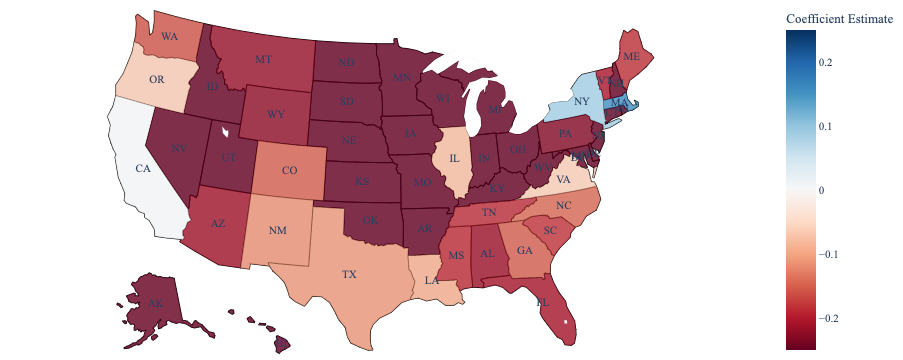

In [68]:
state_corr_map = px.choropleth(state_adi_df,
                    locations='states',
                    color='ADI_NATRANK',
                    range_color=[-0.25,0.25],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'ADI_NATRANK'],
                    locationmode='USA-states',
                    labels={'ADI_NATRANK':'Coefficient Estimate'},
                    scope='usa')


state_corr_map = state_corr_map.add_scattergeo(locations=state_adi_df['states'], locationmode='USA-states', text=state_adi_df['states'], mode='text')

state_corr_map.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0})

state_corr_map.update_traces(marker_line_width=0, marker_opacity=0.8)
state_corr_map.update_geos(showsubunits=True, subunitcolor="black")

**Regression Coefficient between the shortest transit time to food pantry and national ADI percentile (state)**

### Census + Rural

In [71]:
state_census_df.describe()

intercept      white      black   noschool   bachelor       snap  \
count  51.000000  51.000000  51.000000  51.000000  51.000000  51.000000   
mean   18.459412   0.005098  -0.092549  -0.147255  -0.017843  -0.126275   
std    11.809600   0.118277   0.191769   0.232810   0.115088   0.084023   
min    -4.430000  -0.340000  -0.820000  -0.680000  -0.360000  -0.300000   
25%    10.970000  -0.060000  -0.165000  -0.265000  -0.095000  -0.190000   
50%    17.300000   0.030000  -0.090000  -0.180000  -0.020000  -0.130000   
75%    24.190000   0.075000  -0.000000  -0.070000   0.055000  -0.075000   
max    46.090000   0.350000   0.520000   0.580000   0.280000   0.120000   

        unemploy  single_parent    married    cohabit   hispanic       rural  
count  51.000000      51.000000  51.000000  51.000000  51.000000   51.000000  
mean   -0.015686       0.145098   0.284314   0.044706  -0.146667    4.550196  
std     0.135650       0.090297   0.075373   0.125082   0.156865   29.148932  
min    -0.280000      -0.050000   0.140000  -0.340000  -0.840000  -20.880000  
25%    -0.080000       0.080000   0.250000  -0.015000  -0.165000    0.000000  
50%    -0.020000       0.140000   0.280000   0.020000  -0.120000    0.000000  
75%     0.015000       0.200000   0.315000   0.110000  -0.080000    3.995000  
max     0.540000       0.430000   0.550000   0.360000   0.090000  204.040000

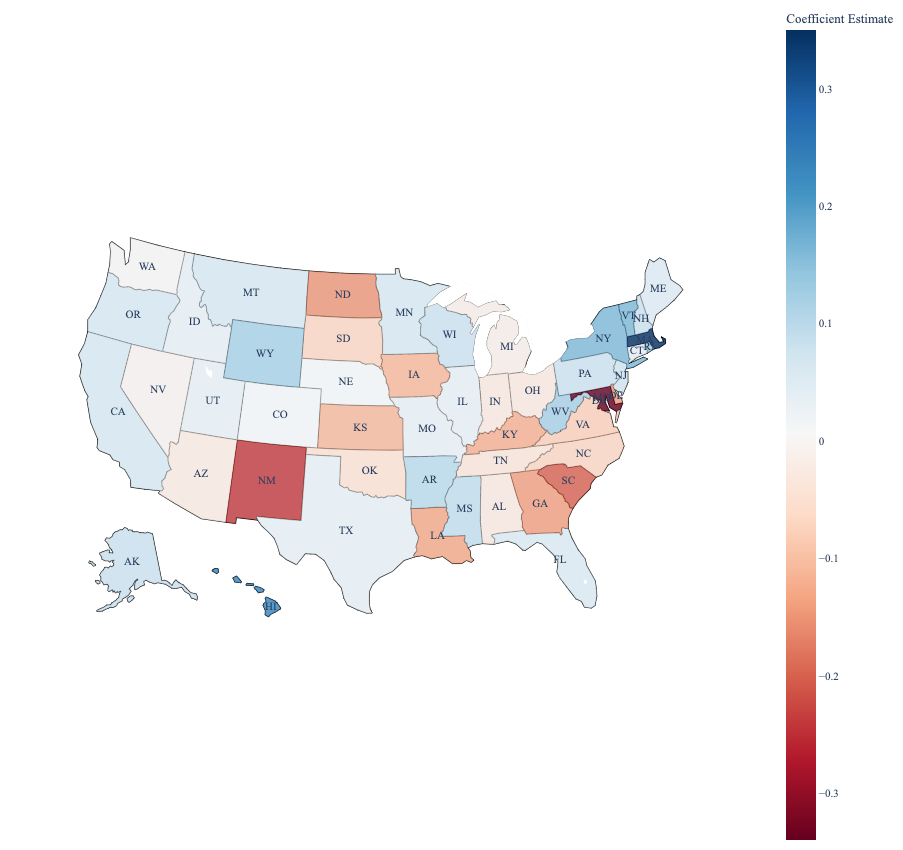

In [86]:
state_white = px.choropleth(state_census_df,
                    locations='states',
                    color='white',
                    range_color=[-0.34,0.35],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'white'],
                    locationmode='USA-states',
                    labels={'white':'Coefficient Estimate'},
                    scope='usa')


state_white = state_white.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_white.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_white.update_traces(marker_line_width=0, marker_opacity=0.8)
state_white.update_geos(showsubunits=True, subunitcolor="black")

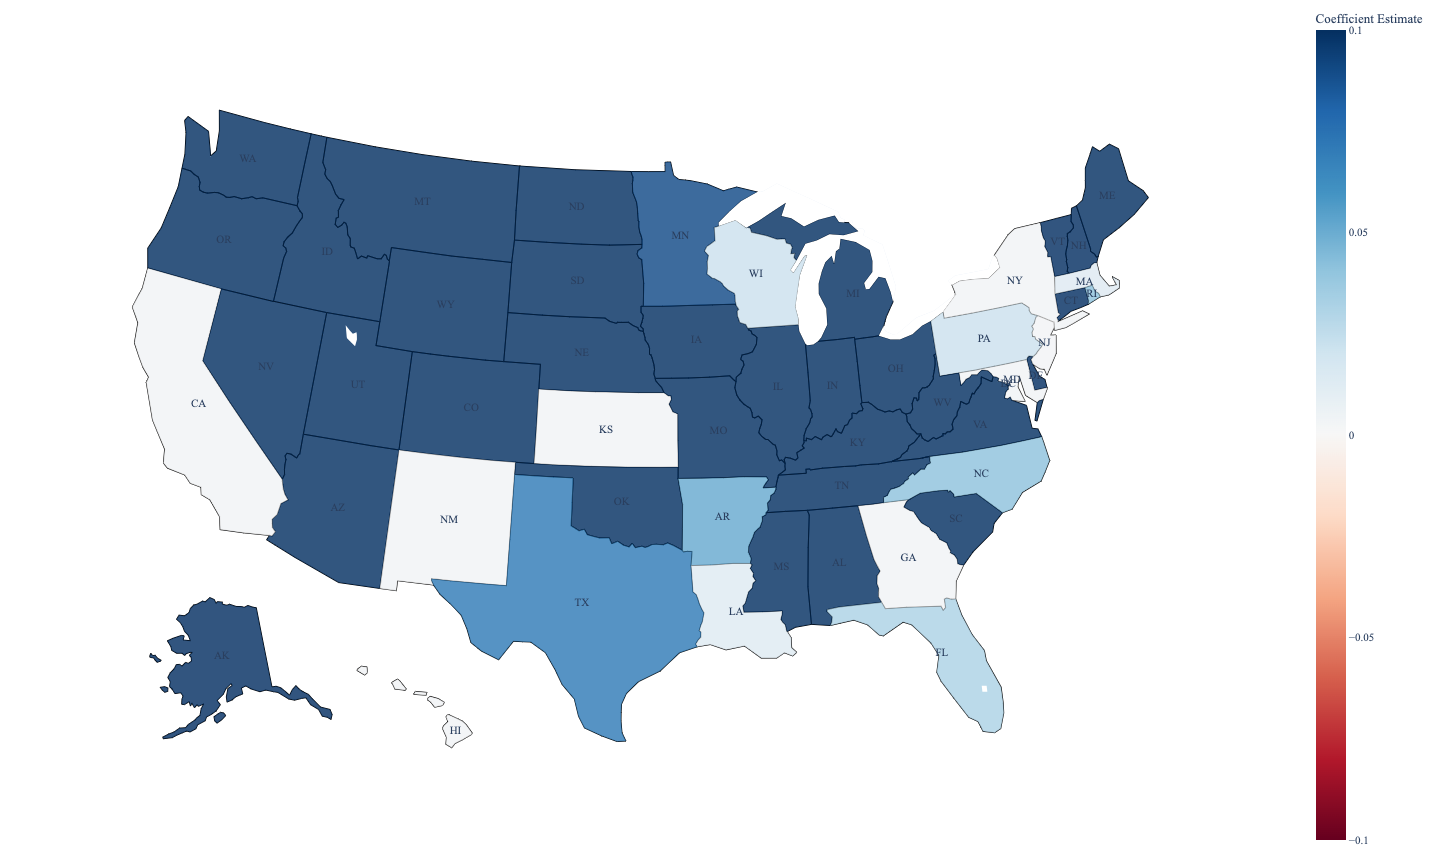

In [116]:
state_white_p = px.choropleth(state_census_df_pvalues,
                    locations='states',
                    color='white',
                    range_color=[-0.1,0.1],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'white'],
                    locationmode='USA-states',
                    labels={'white':'Coefficient Estimate'},
                    scope='usa')


state_white_p = state_white_p.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_white_p.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_white_p.update_traces(marker_line_width=0, marker_opacity=0.8)
state_white_p.update_geos(showsubunits=True, subunitcolor="black")

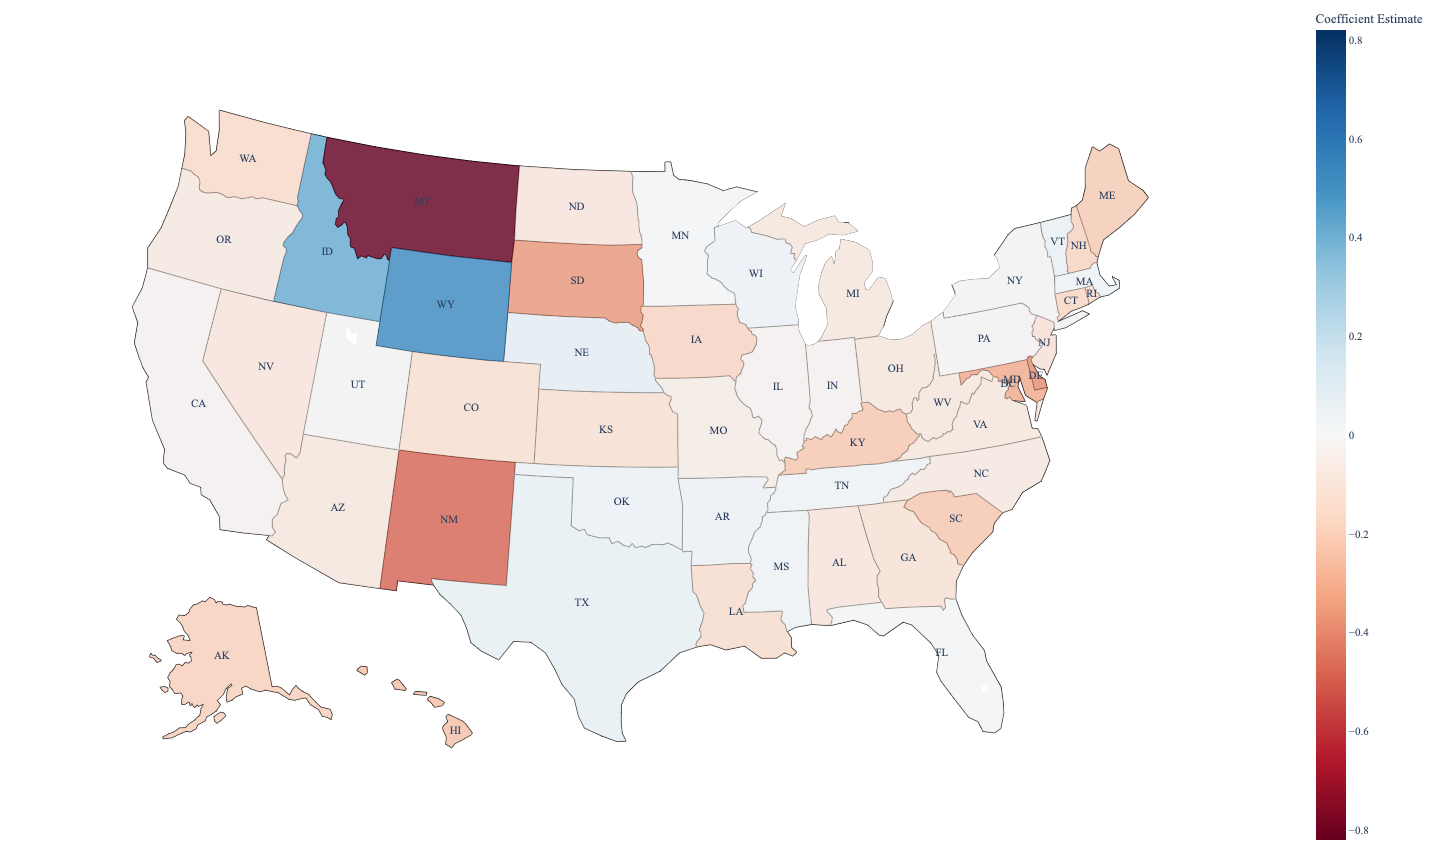

In [101]:
state_black = px.choropleth(state_census_df,
                    locations='states',
                    color='black',
                    range_color=[-0.82,0.82],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'black'],
                    locationmode='USA-states',
                    labels={'black':'Coefficient Estimate'},
                    scope='usa')


state_black = state_black.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_black.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_black.update_traces(marker_line_width=0, marker_opacity=0.8)
state_black.update_geos(showsubunits=True, subunitcolor="black")

In [87]:
state_census_df.describe()

intercept      white      black   noschool   bachelor       snap  \
count  51.000000  51.000000  51.000000  51.000000  51.000000  51.000000   
mean   18.459412   0.005098  -0.092549  -0.147255  -0.017843  -0.126275   
std    11.809600   0.118277   0.191769   0.232810   0.115088   0.084023   
min    -4.430000  -0.340000  -0.820000  -0.680000  -0.360000  -0.300000   
25%    10.970000  -0.060000  -0.165000  -0.265000  -0.095000  -0.190000   
50%    17.300000   0.030000  -0.090000  -0.180000  -0.020000  -0.130000   
75%    24.190000   0.075000  -0.000000  -0.070000   0.055000  -0.075000   
max    46.090000   0.350000   0.520000   0.580000   0.280000   0.120000   

        unemploy  single_parent    married    cohabit   hispanic       rural  
count  51.000000      51.000000  51.000000  51.000000  51.000000   51.000000  
mean   -0.015686       0.145098   0.284314   0.044706  -0.146667    4.550196  
std     0.135650       0.090297   0.075373   0.125082   0.156865   29.148932  
min    -0.280000      -0.050000   0.140000  -0.340000  -0.840000  -20.880000  
25%    -0.080000       0.080000   0.250000  -0.015000  -0.165000    0.000000  
50%    -0.020000       0.140000   0.280000   0.020000  -0.120000    0.000000  
75%     0.015000       0.200000   0.315000   0.110000  -0.080000    3.995000  
max     0.540000       0.430000   0.550000   0.360000   0.090000  204.040000

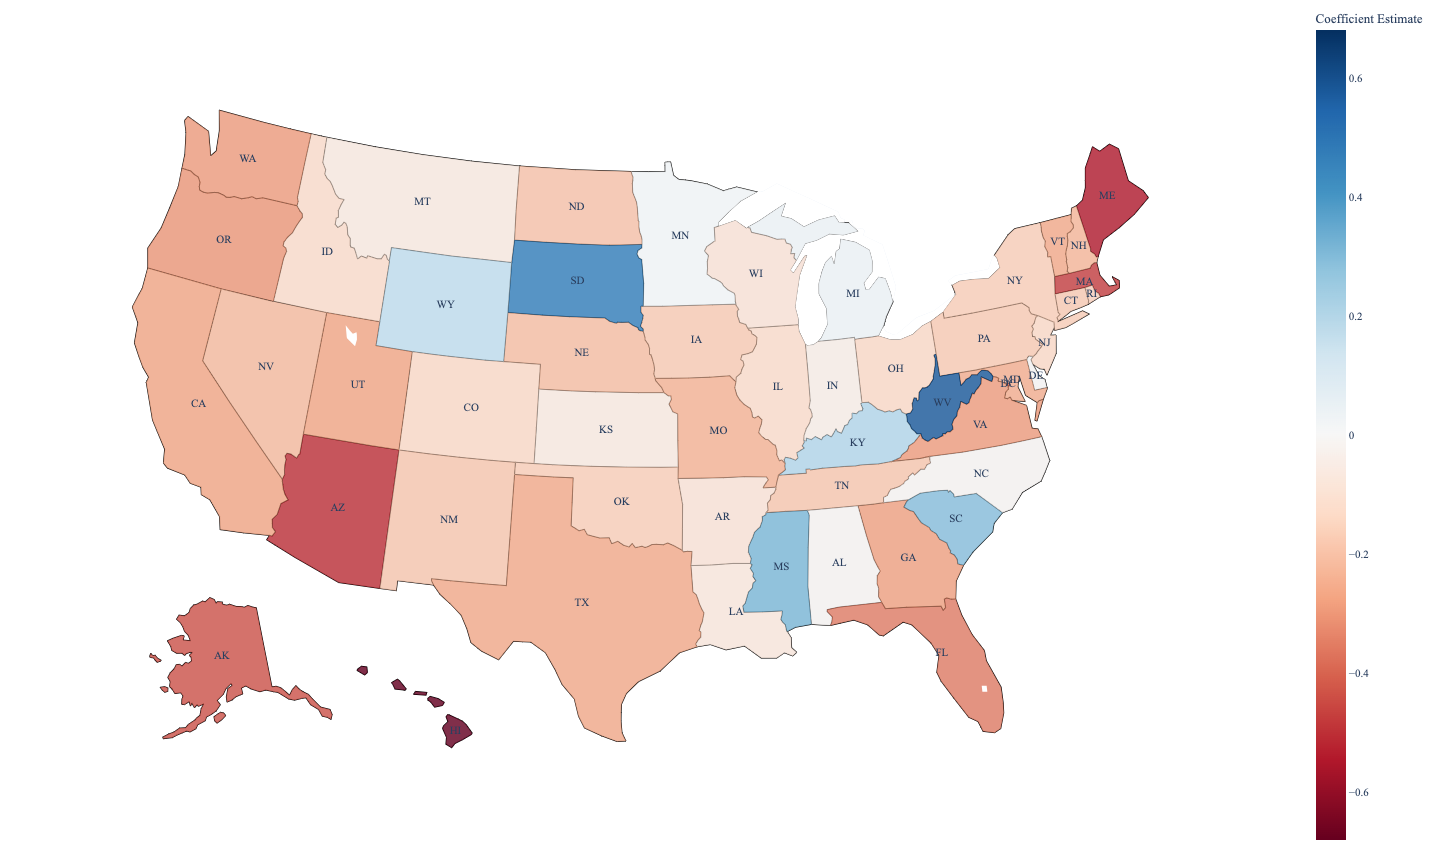

In [102]:
state_noschool = px.choropleth(state_census_df,
                    locations='states',
                    color='noschool',
                    range_color=[-0.68,0.68],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'noschool'],
                    locationmode='USA-states',
                    labels={'noschool':'Coefficient Estimate'},
                    scope='usa')


state_noschool = state_noschool.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_noschool.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_noschool.update_traces(marker_line_width=0, marker_opacity=0.8)
state_noschool.update_geos(showsubunits=True, subunitcolor="black")

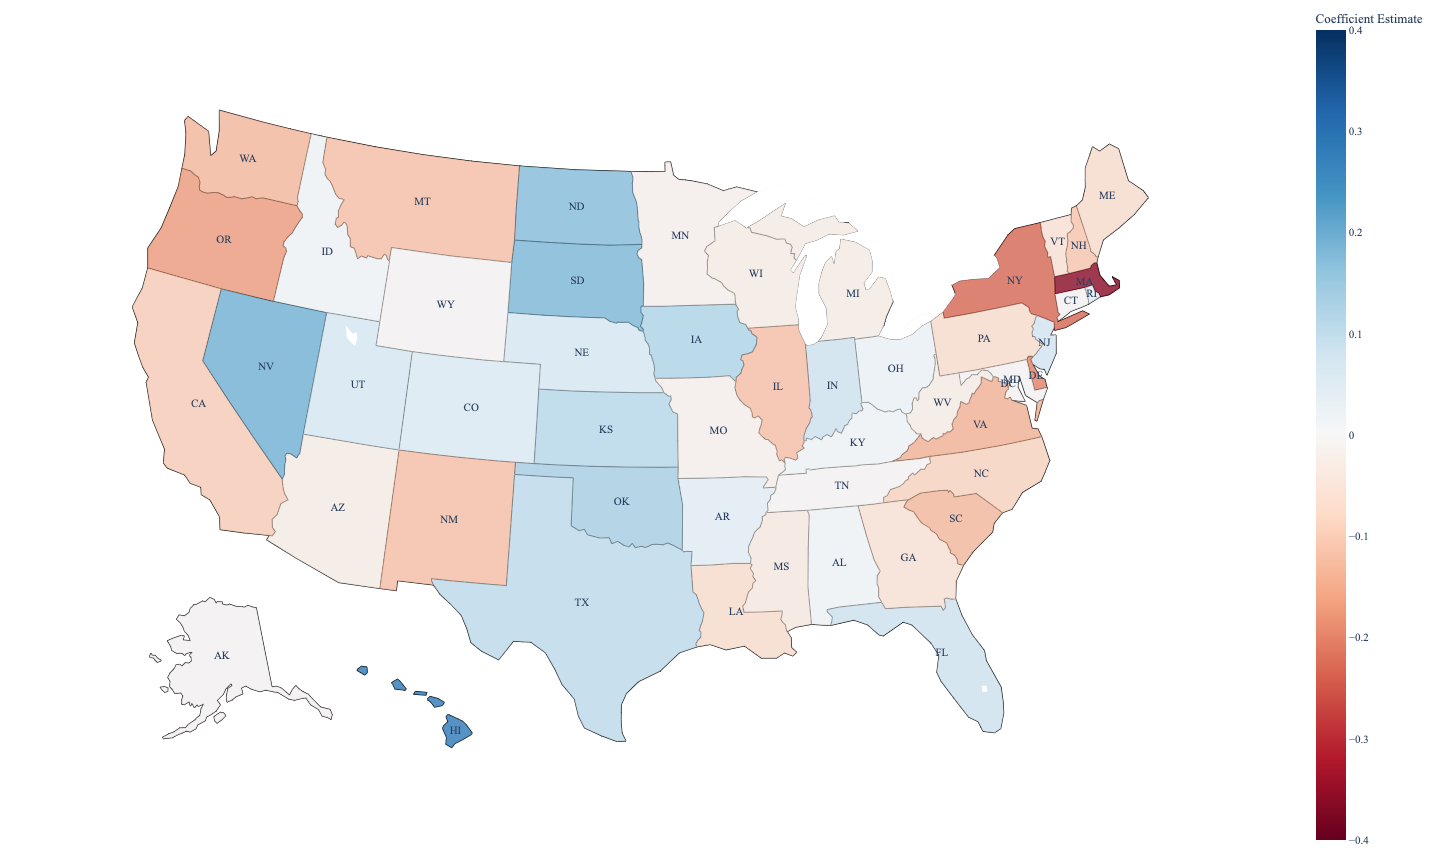

In [103]:
state_bac = px.choropleth(state_census_df,
                    locations='states',
                    color='bachelor',
                    range_color=[-0.40,0.40],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'bachelor'],
                    locationmode='USA-states',
                    labels={'bachelor':'Coefficient Estimate'},
                    scope='usa')


state_bac = state_bac.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_bac.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_bac.update_traces(marker_line_width=0, marker_opacity=0.8)
state_bac.update_geos(showsubunits=True, subunitcolor="black")

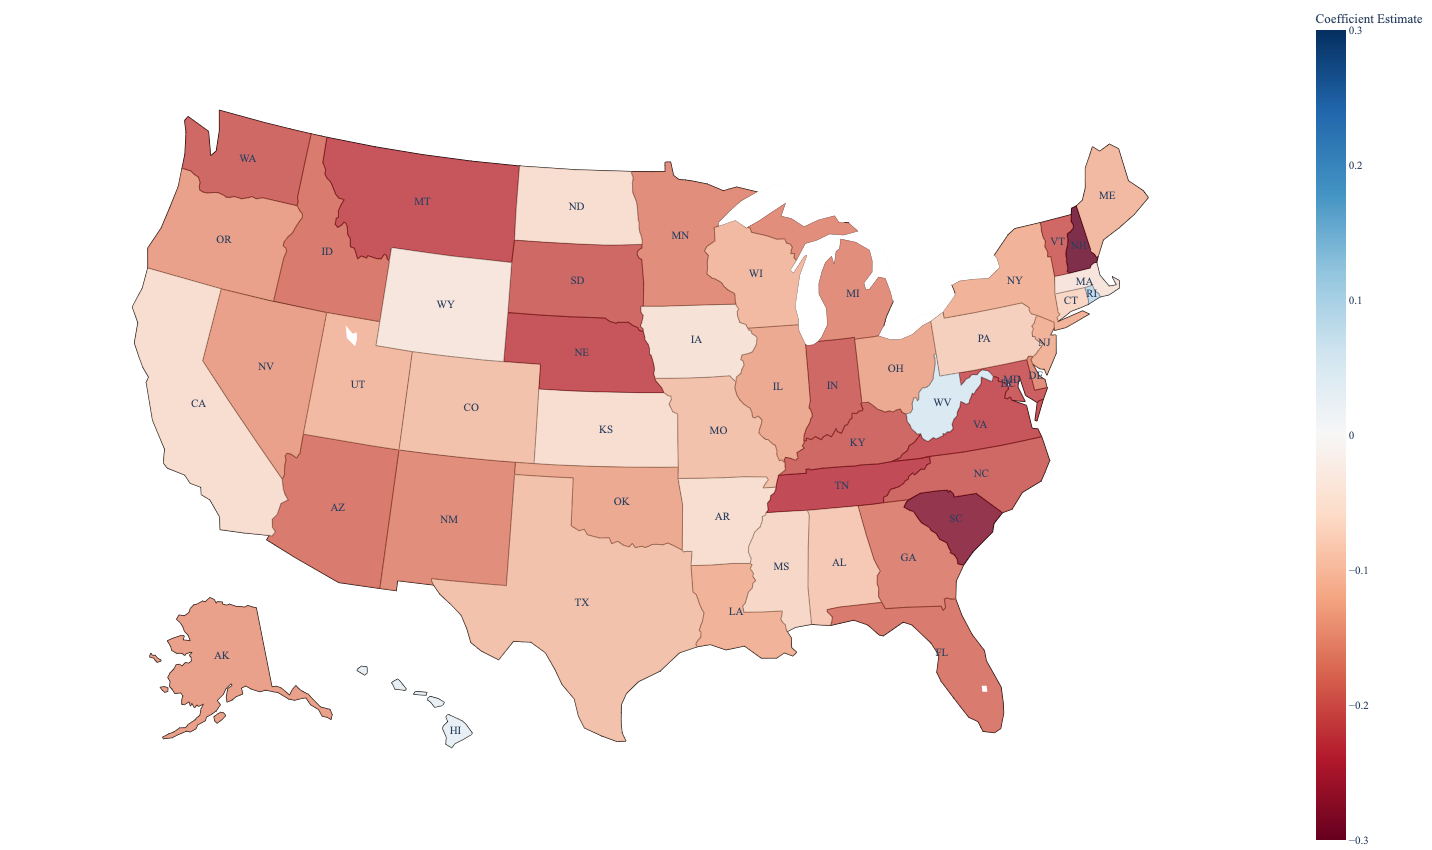

In [104]:
state_snap = px.choropleth(state_census_df,
                    locations='states',
                    color='snap',
                    range_color=[-0.30,0.30],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'snap'],
                    locationmode='USA-states',
                    labels={'snap':'Coefficient Estimate'},
                    scope='usa')


state_snap = state_snap.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_snap.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_snap.update_traces(marker_line_width=0, marker_opacity=0.8)
state_snap.update_geos(showsubunits=True, subunitcolor="black")

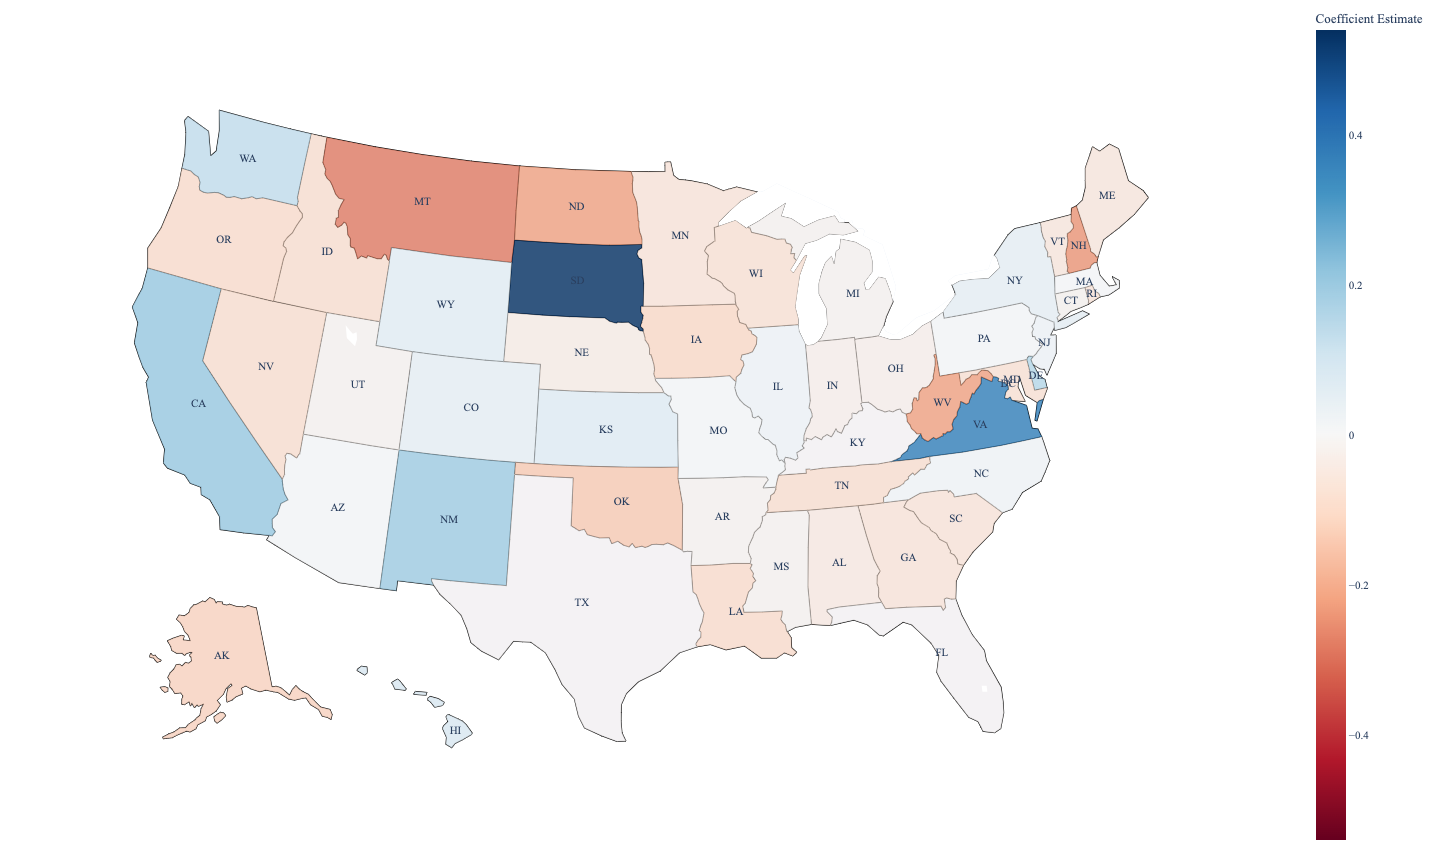

In [105]:
state_unemploy = px.choropleth(state_census_df,
                    locations='states',
                    color='unemploy',
                    range_color=[-0.54,0.54],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'unemploy'],
                    locationmode='USA-states',
                    labels={'unemploy':'Coefficient Estimate'},
                    scope='usa')


state_unemploy = state_unemploy.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_unemploy.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_unemploy.update_traces(marker_line_width=0, marker_opacity=0.8)
state_unemploy.update_geos(showsubunits=True, subunitcolor="black")

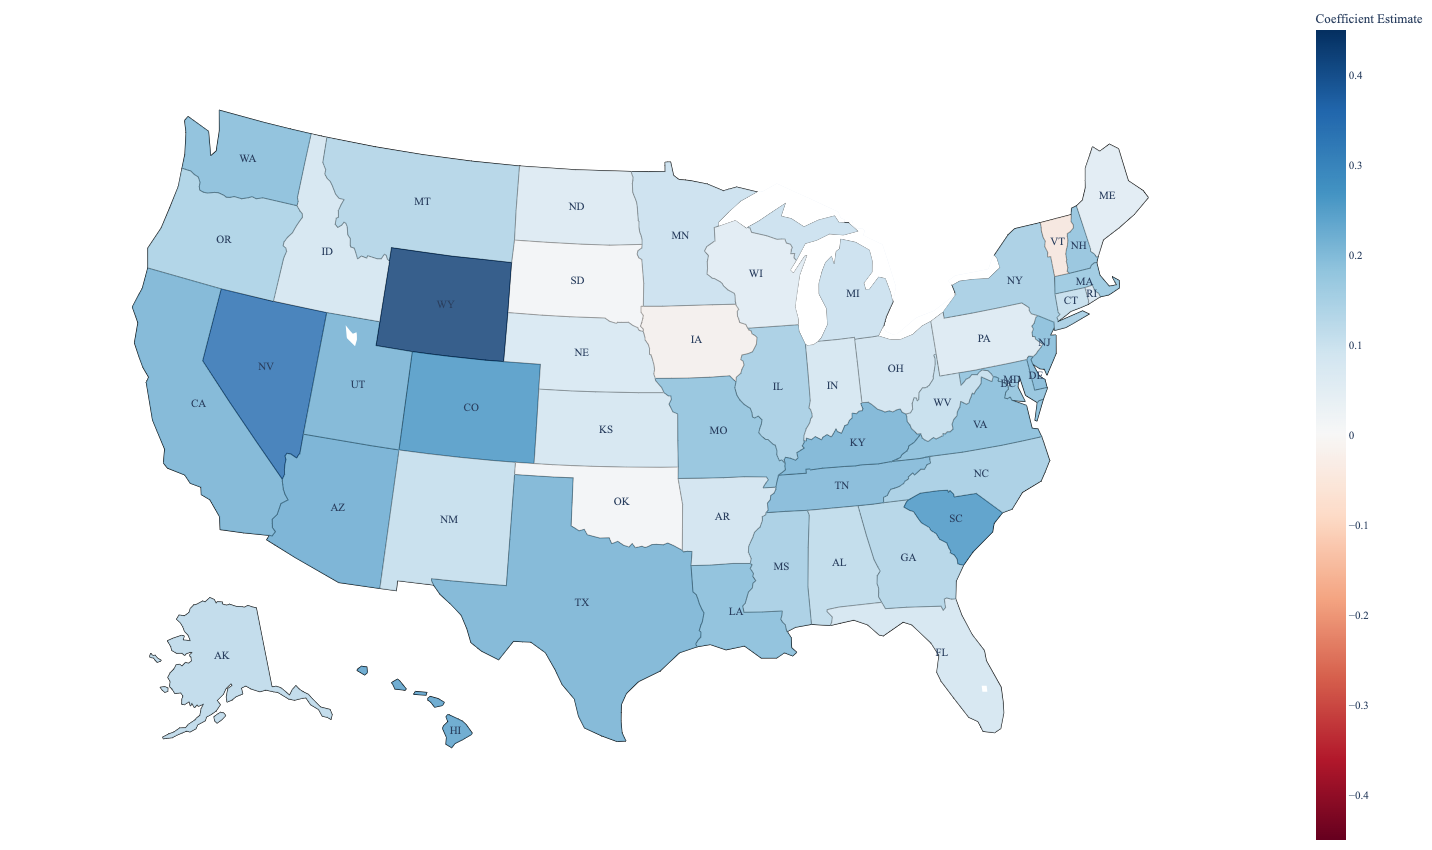

In [106]:
state_single = px.choropleth(state_census_df,
                    locations='states',
                    color='single_parent',
                    range_color=[-0.45,0.45],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'single_parent'],
                    locationmode='USA-states',
                    labels={'single_parent':'Coefficient Estimate'},
                    scope='usa')


state_single = state_single.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_single.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_single.update_traces(marker_line_width=0, marker_opacity=0.8)
state_single.update_geos(showsubunits=True, subunitcolor="black")

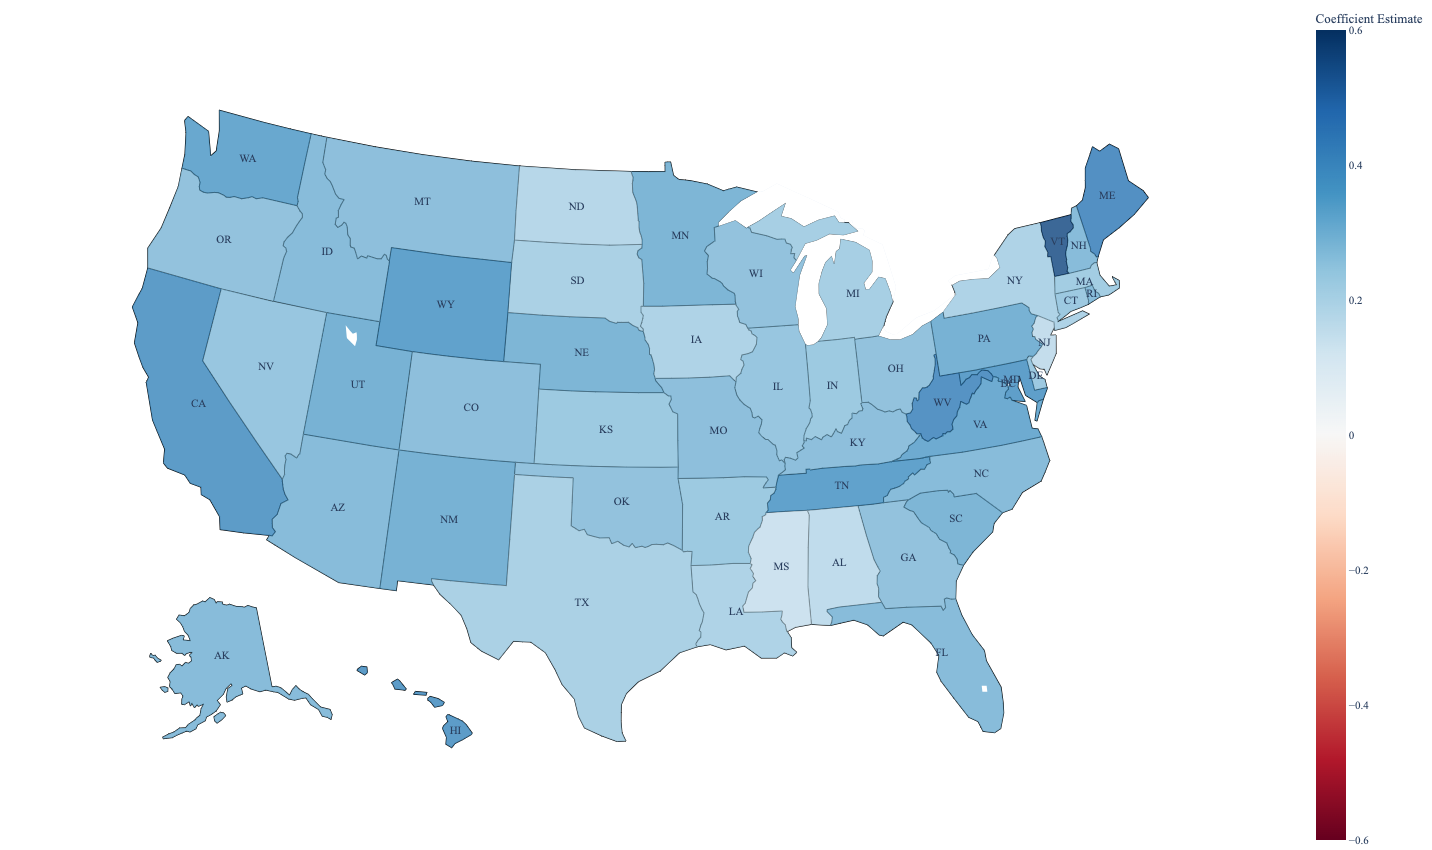

In [107]:
state_married = px.choropleth(state_census_df,
                    locations='states',
                    color='married',
                    range_color=[-0.6,0.6],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'married'],
                    locationmode='USA-states',
                    labels={'married':'Coefficient Estimate'},
                    scope='usa')


state_married = state_married.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_married.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_married.update_traces(marker_line_width=0, marker_opacity=0.8)
state_married.update_geos(showsubunits=True, subunitcolor="black")

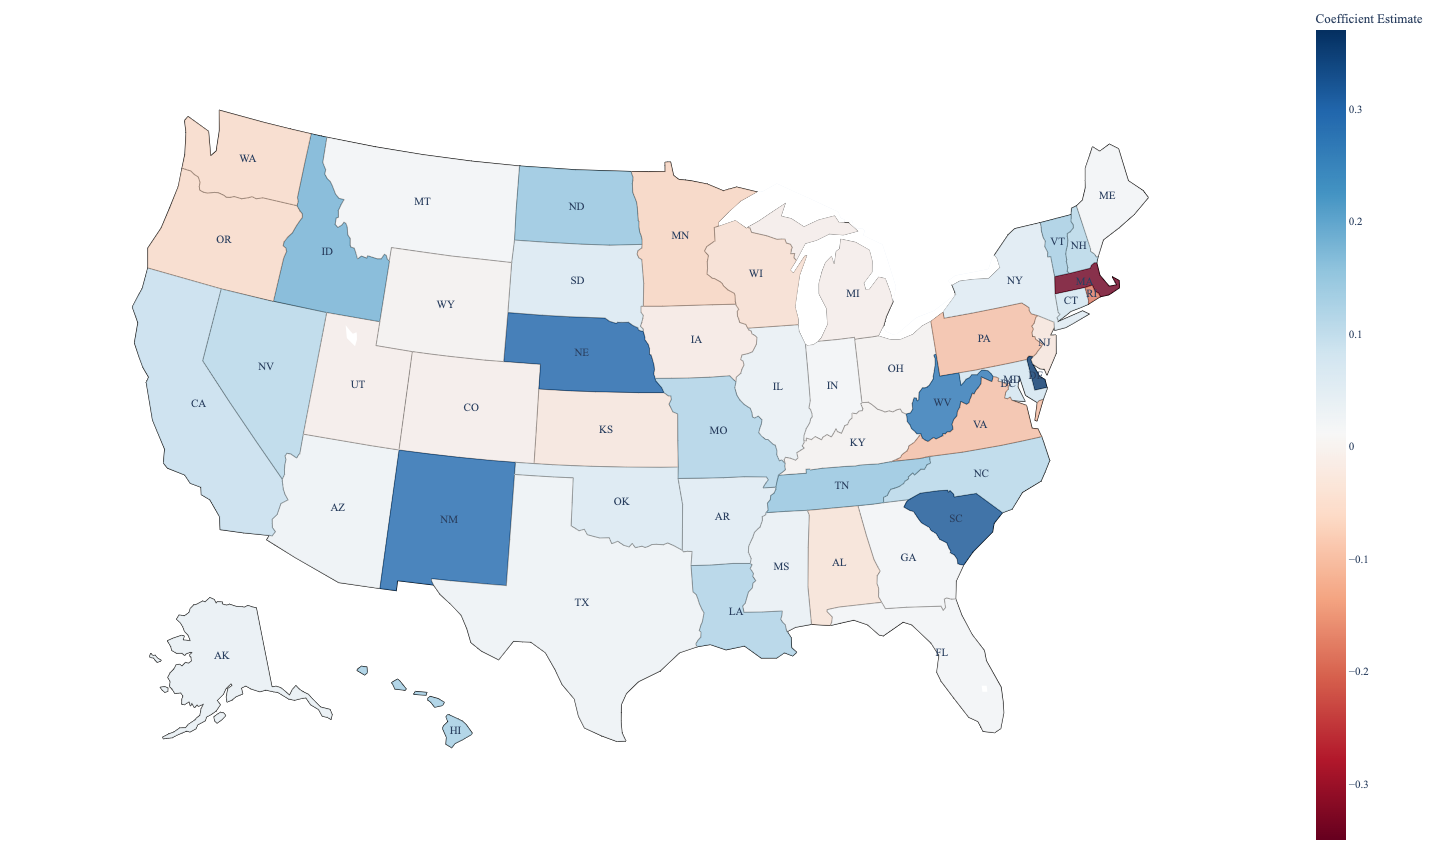

In [108]:
state_cohabit = px.choropleth(state_census_df,
                    locations='states',
                    color='cohabit',
                    range_color=[-0.35,0.37],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'cohabit'],
                    locationmode='USA-states',
                    labels={'cohabit':'Coefficient Estimate'},
                    scope='usa')


state_cohabit = state_cohabit.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_cohabit.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_cohabit.update_traces(marker_line_width=0, marker_opacity=0.8)
state_cohabit.update_geos(showsubunits=True, subunitcolor="black")

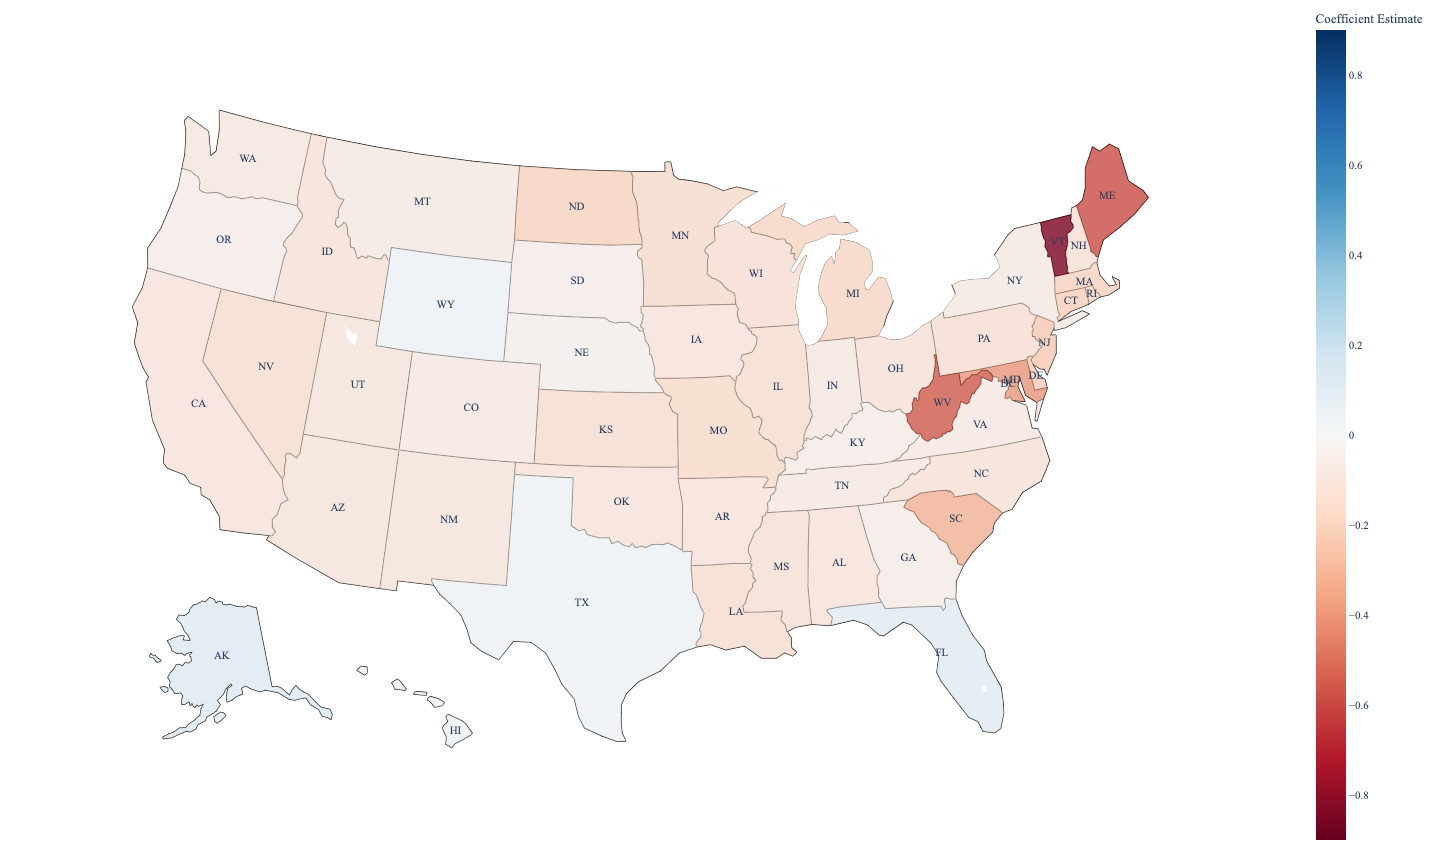

In [109]:
state_hispanic = px.choropleth(state_census_df,
                    locations='states',
                    color='hispanic',
                    range_color=[-0.9,0.9],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'hispanic'],
                    locationmode='USA-states',
                    labels={'hispanic':'Coefficient Estimate'},
                    scope='usa')


state_hispanic = state_hispanic.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_hispanic.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_hispanic.update_traces(marker_line_width=0, marker_opacity=0.8)
state_hispanic.update_geos(showsubunits=True, subunitcolor="black")

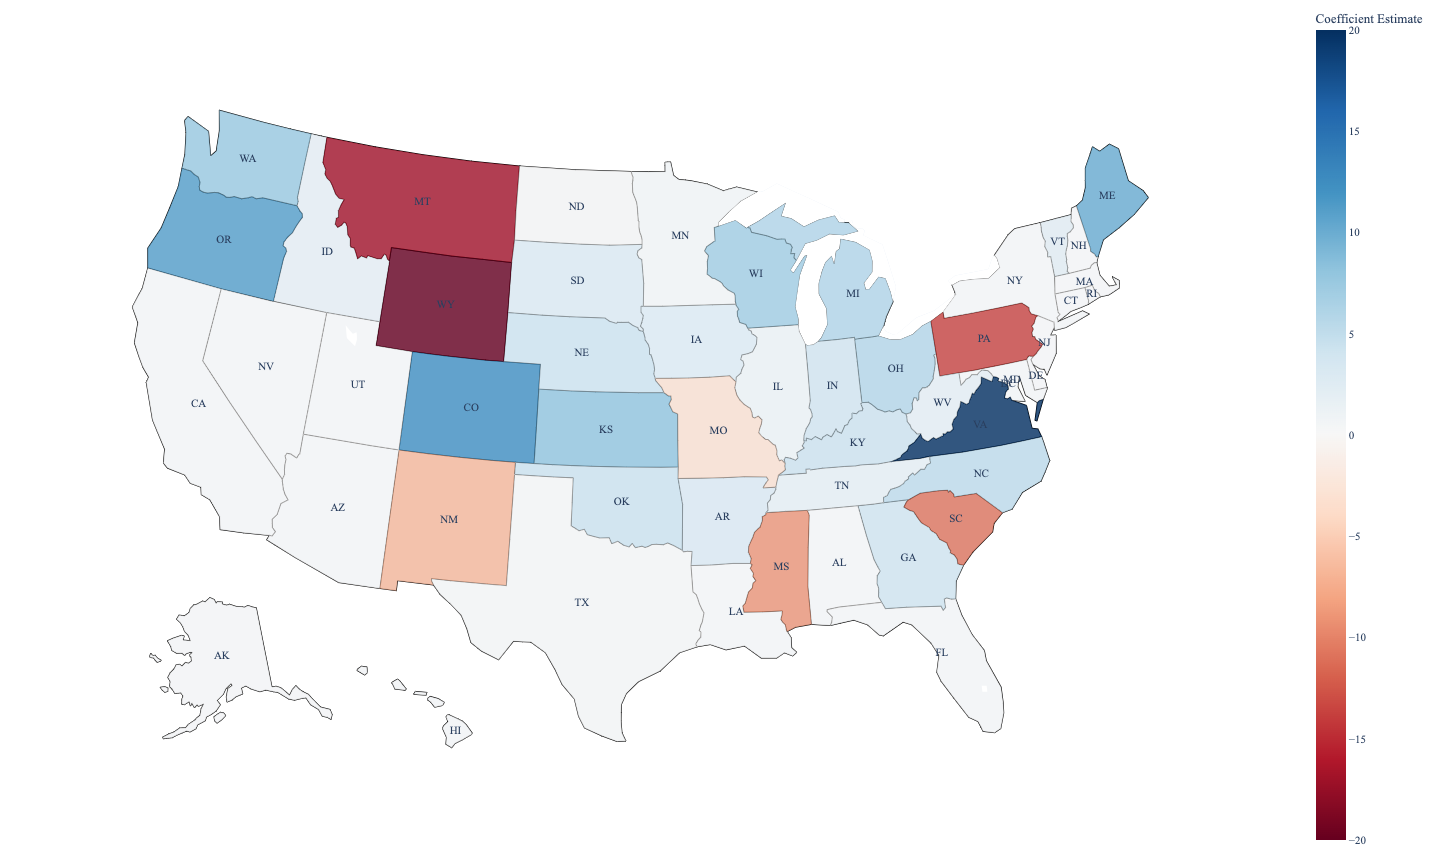

In [112]:
state_rural = px.choropleth(state_census_df,
                    locations='states',
                    color='rural',
                    range_color=[-20, 20],
                    color_continuous_scale=px.colors.diverging.RdBu,
                    color_continuous_midpoint=0,
                    #color_continuous_scale='spectral_r',
                    #color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                    #                        (0.50, "blue"),  (1.00, "blue")],          
                    hover_data=['states', 
                                'rural'],
                    locationmode='USA-states',
                    labels={'rural':'Coefficient Estimate'},
                    scope='usa')


state_rural = state_rural.add_scattergeo(locations=state_census_df['states'], locationmode='USA-states', text=state_census_df['states'], mode='text')

state_rural.update_layout(#title_text = 'Coefficient Estimate between the shortet transit time  and ADI percentile (State)', 
                            legend_orientation='h', 
                            font_size = 11, font_family="Times New Roman",
                            margin={"r":0,"t":0,"l":0,"b":0}, autosize=False, height=850, width=1000)

state_rural.update_traces(marker_line_width=0, marker_opacity=0.8)
state_rural.update_geos(showsubunits=True, subunitcolor="black")

In [113]:
state_census_df_pvalues

states  intercept  white  black  noschool  bachelor  snap  unemploy  \
0      AL       0.00   0.66   0.10      0.89      0.82  0.01      0.43   
1      AK       0.19   0.25   0.24      0.49      0.95  0.22      0.50   
2      AZ       0.00   0.45   0.20      0.00      0.52  0.00      0.95   
3      AR       0.05   0.05   0.51      0.57      0.38  0.17      0.81   
4      CA       0.00   0.00   0.25      0.00      0.00  0.02      0.00   
5      CO       0.00   0.78   0.01      0.26      0.08  0.01      0.56   
6      CT       0.00   0.39   0.00      0.25      0.81  0.06      0.74   
7      DE       0.00   0.14   0.00      0.99      0.03  0.08      0.30   
8      DC       0.09   0.89   0.52      0.15      0.05  0.09      0.54   
9      FL       0.00   0.03   0.89      0.00      0.00  0.00      0.68   
10     GA       0.00   0.00   0.00      0.02      0.04  0.00      0.17   
11     HI       0.36   0.00   0.17      0.06      0.00  0.82      0.65   
12     ID       0.09   0.65   0.03      0.58      0.77  0.00      0.43   
13     IL       0.00   0.19   0.15      0.17      0.00  0.00      0.57   
14     IN       0.00   0.32   0.31      0.57      0.00  0.00      0.44   
15     IA       0.00   0.11   0.06      0.45      0.03  0.44      0.33   
16     KS       0.00   0.00   0.01      0.60      0.00  0.20      0.40   
17     KY       0.00   0.17   0.02      0.45      0.82  0.00      0.89   
18     LA       0.00   0.01   0.00      0.56      0.07  0.00      0.03   
19     ME       0.41   0.67   0.21      0.24      0.33  0.11      0.69   
20     MD       0.00   0.00   0.00      0.40      0.87  0.01      0.58   
21     MA       0.77   0.01   0.91      0.40      0.02  0.82      0.99   
22     MI       0.00   0.31   0.00      0.73      0.27  0.00      0.48   
23     MN       0.01   0.09   0.98      0.95      0.56  0.00      0.47   
24     MS       0.04   0.36   0.81      0.15      0.58  0.18      0.78   
25     MO       0.00   0.36   0.09      0.07      0.39  0.00      0.93   
26     MT       0.01   0.29   0.01      0.91      0.07  0.01      0.05   
27     NE       0.30   0.89   0.58      0.33      0.44  0.03      0.83   
28     NV       0.00   0.69   0.05      0.07      0.00  0.00      0.16   
29     NH       0.14   0.34   0.32      0.50      0.10  0.00      0.07   
30     NJ       0.00   0.00   0.00      0.22      0.02  0.00      0.76   
31     NM       0.00   0.00   0.06      0.61      0.26  0.06      0.21   
32     NY       0.00   0.00   0.33      0.00      0.00  0.00      0.08   
33     NC       0.00   0.04   0.02      0.85      0.00  0.00      0.84   
34     ND       0.01   0.13   0.48      0.63      0.03  0.56      0.25   
35     OH       0.00   0.21   0.00      0.10      0.29  0.00      0.36   
36     OK       0.00   0.14   0.32      0.34      0.00  0.00      0.05   
37     OR       0.00   0.11   0.41      0.09      0.00  0.00      0.20   
38     PA       0.00   0.02   0.60      0.17      0.04  0.01      0.96   
39     RI       0.55   0.04   0.11      0.53      0.66  0.21      0.57   
40     SC       0.00   0.18   0.15      0.46      0.20  0.01      0.60   
41     SD       0.09   0.49   0.03      0.29      0.05  0.08      0.02   
42     TN       0.00   0.46   0.68      0.21      0.85  0.00      0.12   
43     TX       0.00   0.07   0.01      0.00      0.00  0.00      0.72   
44     UT       0.06   0.53   0.95      0.13      0.08  0.06      0.87   
45     VT       0.85   0.30   0.92      0.72      0.57  0.17      0.84   
46     VA       0.00   0.12   0.13      0.22      0.02  0.00      0.00   
47     WA       0.00   0.94   0.01      0.03      0.00  0.00      0.06   
48     WV       0.91   0.51   0.68      0.36      0.82  0.58      0.13   
49     WI       0.00   0.02   0.37      0.37      0.34  0.00      0.24   
50     WY       0.73   0.35   0.19      0.79      0.96  0.76      0.81   

    single_parent  married  cohabit  hispanic  rural  
0            0.01     0.00     0.53      0.06   1.00  
1            0.45     0.00     0.82      0.4